In [8]:
server = 'http://data.cropmap.edina.ac.uk'
url = server+"/2018"
shape_file = "fields.shp"

In [9]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
from rasterio.mask import mask
import pycrs
from matplotlib import pyplot
from rasterio.plot import show_hist
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.mask import mask
from rasterio.plot import plotting_extent

In [10]:
# One way to go through each tif files on the serveur
# TODO: Add timestamp

from bs4 import BeautifulSoup
import requests

all_server_files = []
ext = 'tif'

def listTiffFiles(url, ext=''):
    page = requests.get(url).text
    #print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

def listDirs(url, ext=''):
    page = requests.get(url).text
    #print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith('/') and node.text != "Parent Directory"]

idx = 0
for dir in listDirs(url):
    for subdir in listDirs(dir):
        for subdir2 in listDirs(subdir):
            for url in listTiffFiles(subdir2, ext):
                filename = url[url.rfind("/")+1:]
                file_elem = filename.split("_")
                date = file_elem[1]
                year = date[0:4]
                month = date[4:6]
                day = date[6:]
                timestamp_start = file_elem[4]
                timestamp_end = file_elem[5]
                file_info = {
                    "year": year,
                    "month": month,
                    "day": day,
                    "start": timestamp_start,
                    "end": timestamp_end,
                    "url": url                    
                }
                all_server_files.append(file_info)
                idx += 1
all_server_files

[{'year': '2018',
  'month': '01',
  'day': '07',
  'start': '175836',
  'end': '175901',
  'url': 'http://data.cropmap.edina.ac.uk/2018/01//07//S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif'},
 {'year': '2018',
  'month': '01',
  'day': '13',
  'start': '175748',
  'end': '175813',
  'url': 'http://data.cropmap.edina.ac.uk/2018/01//13//S1B_20180113_30_asc_175748_175813_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1B_20180113_30_asc_175748_175813_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif'},
 {'year': '2018',
  'month': '01',
  'day': '13',
  'start': '175813',
  'end': '175838',
  'url': 'http://data.cropmap.edina.ac.uk/2018/01//13//S1B_20180113_30_asc_175813_175838_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1B_20180113_30_asc_175813_175838_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif'},
 {'year': '2018',
  'month': '01',
  'day': '19',
  'start': '175836',
  'end': '175901',
  'url': 'http://data.cropmap.edina.ac.uk/2018/01//19//S1A_20180119

In [11]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [12]:
all_server_files[0]['url']

'http://data.cropmap.edina.ac.uk/2018/01//07//S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif'

### Create Clipped Files for each Field

Go through each server file and create a clipped file for each field in the `.shp` file.

In [13]:
import urllib.request as urllib2

shapefile = gpd.read_file('fields.shp')
clipped_files = []

clipped_folder = "data/clipped/fields"

first_field = 0
last_field = 100
first_file = 0

for i, server_file in enumerate(all_server_files[first_file:]):
    
    print("\nfile {}: {}".format(str(i+first_file), server_file['url']))
    
    with rasterio.open(server_file['url']) as data:
        big_bbox = data.bounds
    
        for index, shape in enumerate(shapefile['geometry'][first_field:last_field]):
            print("\nfield "+str(index)+": ")

            # get a GeoSeries of geometries representing the smallest rectangular polygon 
            # (with sides parallel to the coordinate axes) that contains each object.
            rec_polygon = shape.envelope

            # Get points of rectangle
            points = []
            for pt in list(rec_polygon.exterior.coords):
                points.append(pt)
                print(pt)

            # Get BBox
            minx, miny = points[0]
            maxx, maxy = points[2]
            bbox = box(minx, miny, maxx, maxy)

            # BoundingBox(left, bottom, right, top)
            field_bbox = rasterio.coords.BoundingBox(minx, miny, maxx, maxy)

            if (not rasterio.coords.disjoint_bounds(big_bbox, field_bbox)):
                geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(27700))
                geo = geo.to_crs(crs=data.crs.data)

                coords = getFeatures(geo)
                print("\n coords: "+str(coords))

                out_img, out_transform = mask(data, shapes=coords, crop=True)

                out_meta = data.meta.copy()
                print("\n out_meta: "+str(out_meta))

                epsg_code = int(data.crs.data['init'][5:])
                print("\n epsg_code: "+str(epsg_code))
                
                tries = 0
                try:
                    tries += 1
                    out_meta.update({"driver": "GTiff",
                                     "height": out_img.shape[1],
                                     "width": out_img.shape[2],
                                     "transform": out_transform,
                                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                                   )
                except urllib2.HTTPError as err:
                    if err.code == 502:
                        print("\n Fail to access: {} for field {}".format(server_file, index))
                        # occasionally with 502 error
                        if tries > 3:
                            raise
                    else:
                        raise
                        
                field_folder = str(first_field + index)
                
                # create dir if doesn't exist
                directory = "{}/{}".format(clipped_folder, field_folder)
                if not os.path.exists(directory):
                    os.makedirs(directory) 
                
                file = "clipped_{}{}{}_{}_{}.tif".format(
                    server_file['year'],server_file['month'],server_file['day'],
                    server_file['start'],server_file['end']
                )

                
                print("\n create file: {}/{}/{}".format(clipped_folder, field_folder, file))
                
                field_folder = str(first_field + index)
                
                # write clipped file
                with rasterio.open("{}/{}/{}".format(clipped_folder, field_folder, file), "w", **out_meta) as dest:
                    dest.write(out_img)

                clipped_files.append(file)
            else:
                print("\n\t####################\n\tBox: {} not in tif: {}\n\t####################"
                      .format(str(bbox), str(big_bbox)))


file 0: http://data.cropmap.edina.ac.uk/2018/01//07//S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif

field 0: 
(364387.25, 623710.9344500001)
(364733.05, 623710.9344500001)
(364733.05, 624188.8685399999)
(364387.25, 624188.8685399999)
(364387.25, 623710.9344500001)

 coords: [{'type': 'Polygon', 'coordinates': [[[364733.0499999998, 623710.9344499994], [364733.0499999998, 624188.8685400002], [364387.2499999998, 624188.8685399998], [364387.2499999998, 623710.9344499992], [364733.0499999998, 623710.9344499994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29819, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)}

 epsg_code: 27700

 create file: data/clipped/fields/0/clipped_20180107_175836_175901.tif

field 1: 
(364528.41533, 623760.43002)
(365000.66411, 623760.


 create file: data/clipped/fields/10/clipped_20180107_175836_175901.tif

field 11: 
(364726.81, 624024.15)
(365021.457, 624024.15)
(365021.457, 624479.41)
(364726.81, 624479.41)
(364726.81, 624024.15)

 coords: [{'type': 'Polygon', 'coordinates': [[[365021.4569999999, 624024.149999999], [365021.4569999998, 624479.4100000001], [364726.8099999998, 624479.4099999992], [364726.8099999998, 624024.1499999987], [365021.4569999999, 624024.149999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29819, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)}

 epsg_code: 27700

 create file: data/clipped/fields/11/clipped_20180107_175836_175901.tif

field 12: 
(365030.62888, 624098.08268)
(365557.40831, 624098.08268)
(365557.40831, 624474.8520900001)
(365030.62888, 624474.8520900001)
(365030.62888, 624098.08268)

 coords: [{'type': 'Polygon', 'coordinates': [


 create file: data/clipped/fields/22/clipped_20180107_175836_175901.tif

field 23: 
(365398.03043221147, 623044.24003)
(365649.52, 623044.24003)
(365649.52, 623448.61056)
(365398.03043221147, 623448.61056)
(365398.03043221147, 623044.24003)

 coords: [{'type': 'Polygon', 'coordinates': [[[365649.5199999999, 623044.2400300002], [365649.5199999999, 623448.6105599996], [365398.03043221135, 623448.61056], [365398.03043221135, 623044.2400299999], [365649.5199999999, 623044.2400300002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29819, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)}

 epsg_code: 27700

 create file: data/clipped/fields/23/clipped_20180107_175836_175901.tif

field 24: 
(365526.31, 630838.59)
(365795.231, 630838.59)
(365795.231, 631123.76)
(365526.31, 631123.76)
(365526.31, 630838.59)

 coords: [{'type': 'Polygon', 'coordinates': 


 create file: data/clipped/fields/34/clipped_20180107_175836_175901.tif

field 35: 
(364941.75, 622874.48)
(365229.87, 622874.48)
(365229.87, 623243.316)
(364941.75, 623243.316)
(364941.75, 622874.48)

 coords: [{'type': 'Polygon', 'coordinates': [[[365229.8699999999, 622874.479999999], [365229.8699999999, 623243.3159999998], [364941.7499999999, 623243.3159999998], [364941.7499999999, 622874.4799999986], [365229.8699999999, 622874.479999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29819, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)}

 epsg_code: 27700

 create file: data/clipped/fields/35/clipped_20180107_175836_175901.tif

field 36: 
(365801.974, 622811.57)
(365965.32, 622811.57)
(365965.32, 623163.79)
(365801.974, 623163.79)
(365801.974, 622811.57)

 coords: [{'type': 'Polygon', 'coordinates': [[[365965.3199999999, 622811.569999999


 create file: data/clipped/fields/46/clipped_20180107_175836_175901.tif

field 47: 
(366365.477, 620111.712)
(366826.306, 620111.712)
(366826.306, 620555.905)
(366365.477, 620555.905)
(366365.477, 620111.712)

 coords: [{'type': 'Polygon', 'coordinates': [[[366826.30599999987, 620111.7119999996], [366826.30599999987, 620555.9049999993], [366365.4769999999, 620555.9049999984], [366365.4769999999, 620111.7119999992], [366826.30599999987, 620111.7119999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29819, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)}

 epsg_code: 27700

 Fail to access: {'year': '2018', 'month': '01', 'day': '07', 'start': '175836', 'end': '175901', 'url': 'http://data.cropmap.edina.ac.uk/2018/01//07//S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1A_20180107_30_asc_175836_175901_DV_Gamma-0_GB_OSGB_RCTK


 create file: data/clipped/fields/57/clipped_20180107_175836_175901.tif

field 58: 
(371691.90780150326, 630881.52)
(372412.54, 630881.52)
(372412.54, 631530.18)
(371691.90780150326, 631530.18)
(371691.90780150326, 630881.52)

 coords: [{'type': 'Polygon', 'coordinates': [[[372412.5399999999, 630881.5200000001], [372412.5399999999, 631530.1799999992], [371691.9078015032, 631530.1799999994], [371691.90780150326, 630881.5200000004], [372412.5399999999, 630881.5200000001]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29819, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)}

 epsg_code: 27700

 create file: data/clipped/fields/58/clipped_20180107_175836_175901.tif

field 59: 
(371985.73, 630684.9811918199)
(372541.701, 630684.9811918199)
(372541.701, 631190.999)
(371985.73, 631190.999)
(371985.73, 630684.9811918199)

 coords: [{'type': 'Polygon', 


 create file: data/clipped/fields/69/clipped_20180107_175836_175901.tif

field 70: 
(372126.01, 629565.1230199999)
(372803.10162000003, 629565.1230199999)
(372803.10162000003, 630230.81)
(372126.01, 630230.81)
(372126.01, 629565.1230199999)

 coords: [{'type': 'Polygon', 'coordinates': [[[372803.10162, 629565.1230200004], [372803.10162, 630230.809999999], [372126.00999999995, 630230.81], [372126.00999999995, 629565.1230200005], [372803.10162, 629565.1230200004]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29819, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)}

 epsg_code: 27700

 create file: data/clipped/fields/70/clipped_20180107_175836_175901.tif

field 71: 
(374351.84, 624750.8)
(374488.58, 624750.8)
(374488.58, 625031.168)
(374351.84, 625031.168)
(374351.84, 624750.8)

 coords: [{'type': 'Polygon', 'coordinates': [[[374488.57999999996,


 create file: data/clipped/fields/81/clipped_20180107_175836_175901.tif

field 82: 
(373221.54, 624498.711)
(373573.24, 624498.711)
(373573.24, 624980.56531)
(373221.54, 624980.56531)
(373221.54, 624498.711)

 coords: [{'type': 'Polygon', 'coordinates': [[[373573.23999999993, 624498.7109999998], [373573.23999999993, 624980.5653099993], [373221.5399999999, 624980.5653099994], [373221.5399999999, 624498.7110000002], [373573.23999999993, 624498.7109999998]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29819, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)}

 epsg_code: 27700

 create file: data/clipped/fields/82/clipped_20180107_175836_175901.tif

field 83: 
(372983.28, 625575.6408211131)
(373366.438, 625575.6408211131)
(373366.438, 626183.136698445)
(372983.28, 626183.136698445)
(372983.28, 625575.6408211131)

 coords: [{'type': 'Polygon', 'coo


 create file: data/clipped/fields/93/clipped_20180107_175836_175901.tif

field 94: 
(373947.97442612355, 625389.7468600001)
(374322.41348000005, 625389.7468600001)
(374322.41348000005, 625686.9058548865)
(373947.97442612355, 625686.9058548865)
(373947.97442612355, 625389.7468600001)

 coords: [{'type': 'Polygon', 'coordinates': [[[374322.41348000005, 625389.7468599994], [374322.41348, 625686.9058548867], [373947.9744261235, 625686.9058548863], [373947.97442612355, 625389.7468599991], [374322.41348000005, 625389.7468599994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29819, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154580.59591206638,
       0.0, -10.0, 693426.1972031946)}

 epsg_code: 27700

 create file: data/clipped/fields/94/clipped_20180107_175836_175901.tif

field 95: 
(373727.6, 625184.641)
(374109.35, 625184.641)
(374109.35, 625564.459)
(373727.6, 625564.459)
(373727.6, 625184.641)

 


 create file: data/clipped/fields/4/clipped_20180113_175748_175813.tif

field 5: 
(365686.11284593167, 623356.28)
(366066.35, 623356.28)
(366066.35, 623726.99705)
(365686.11284593167, 623726.99705)
(365686.11284593167, 623356.28)

 coords: [{'type': 'Polygon', 'coordinates': [[[366066.34999999986, 623356.2800000001], [366066.34999999986, 623726.9970499997], [365686.11284593155, 623726.9970499991], [365686.11284593155, 623356.2800000001], [366066.34999999986, 623356.2800000001]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29713, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161983.49413681764,
       0.0, -10.0, 653953.3094556708)}

 epsg_code: 27700

 create file: data/clipped/fields/5/clipped_20180113_175748_175813.tif

field 6: 
(365595.36, 623590.48)
(365870.3, 623590.48)
(365870.3, 623867.8)
(365595.36, 623867.8)
(365595.36, 623590.48)

 coords: [{'type': 'Polygon', 'coordinates': [[[365870.2


 create file: data/clipped/fields/16/clipped_20180113_175748_175813.tif

field 17: 
(365573.3066, 624103.4293600001)
(365972.4, 624103.4293600001)
(365972.4, 624331.27577)
(365573.3066, 624331.27577)
(365573.3066, 624103.4293600001)

 coords: [{'type': 'Polygon', 'coordinates': [[[365972.3999999999, 624103.4293600005], [365972.3999999999, 624331.2757699995], [365573.3065999999, 624331.2757699997], [365573.3065999999, 624103.4293599997], [365972.3999999999, 624103.4293600005]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29713, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161983.49413681764,
       0.0, -10.0, 653953.3094556708)}

 epsg_code: 27700

 create file: data/clipped/fields/17/clipped_20180113_175748_175813.tif

field 18: 
(365019.301, 624021.951)
(365864.85879, 624021.951)
(365864.85879, 624486.97)
(365019.301, 624486.97)
(365019.301, 624021.951)

 coords: [{'type': 'Polygon', 'coordinat


 create file: data/clipped/fields/28/clipped_20180113_175748_175813.tif

field 29: 
(364867.74, 621768.54)
(365161.37, 621768.54)
(365161.37, 622214.15)
(364867.74, 622214.15)
(364867.74, 621768.54)

 coords: [{'type': 'Polygon', 'coordinates': [[[365161.3699999999, 621768.539999999], [365161.3699999999, 622214.15], [364867.7399999998, 622214.1499999998], [364867.7399999999, 621768.5399999992], [365161.3699999999, 621768.539999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29713, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161983.49413681764,
       0.0, -10.0, 653953.3094556708)}

 epsg_code: 27700

 create file: data/clipped/fields/29/clipped_20180113_175748_175813.tif

field 30: 
(364808.15, 621559.52)
(365176.7, 621559.52)
(365176.7, 621819.18)
(364808.15, 621819.18)
(364808.15, 621559.52)

 coords: [{'type': 'Polygon', 'coordinates': [[[365176.6999999999, 621559.5199999993], [365176.699


 create file: data/clipped/fields/40/clipped_20180113_175748_175813.tif

field 41: 
(364492.77063, 621766.11061)
(364864.98, 621766.11061)
(364864.98, 622206.9622887443)
(364492.77063, 622206.9622887443)
(364492.77063, 621766.11061)

 coords: [{'type': 'Polygon', 'coordinates': [[[364864.97999999986, 621766.1106099983], [364864.9799999998, 622206.9622887437], [364492.7706299998, 622206.9622887434], [364492.7706299998, 621766.1106099985], [364864.97999999986, 621766.1106099983]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29713, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161983.49413681764,
       0.0, -10.0, 653953.3094556708)}

 epsg_code: 27700

 create file: data/clipped/fields/41/clipped_20180113_175748_175813.tif

field 42: 
(364462.731, 619705.083)
(364820.764, 619705.083)
(364820.764, 620064.34)
(364462.731, 620064.34)
(364462.731, 619705.083)

 coords: [{'type': 'Polygon', 'coordinates


 create file: data/clipped/fields/52/clipped_20180113_175748_175813.tif

field 53: 
(371880.25, 629753.98)
(372496.09, 629753.98)
(372496.09, 630349.79)
(371880.25, 630349.79)
(371880.25, 629753.98)

 coords: [{'type': 'Polygon', 'coordinates': [[[372496.08999999997, 629753.9799999992], [372496.08999999997, 630349.7899999996], [371880.24999999994, 630349.7899999995], [371880.25, 629753.9799999987], [372496.08999999997, 629753.9799999992]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29713, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161983.49413681764,
       0.0, -10.0, 653953.3094556708)}

 epsg_code: 27700

 create file: data/clipped/fields/53/clipped_20180113_175748_175813.tif

field 54: 
(371455.77, 630445.5806789607)
(371687.32461735944, 630445.5806789607)
(371687.32461735944, 630947.5821384963)
(371455.77, 630947.5821384963)
(371455.77, 630445.5806789607)

 coords: [{'type': 'Polygon', 'c


 create file: data/clipped/fields/64/clipped_20180113_175748_175813.tif

field 65: 
(373374.44520245853, 629549.43164)
(373992.43985, 629549.43164)
(373992.43985, 630109.4)
(373374.44520245853, 630109.4)
(373374.44520245853, 629549.43164)

 coords: [{'type': 'Polygon', 'coordinates': [[[373992.43984999997, 629549.431640001], [373992.43985, 630109.3999999994], [373374.44520245853, 630109.3999999997], [373374.4452024585, 629549.4316399997], [373992.43984999997, 629549.431640001]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29713, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161983.49413681764,
       0.0, -10.0, 653953.3094556708)}

 epsg_code: 27700

 create file: data/clipped/fields/65/clipped_20180113_175748_175813.tif

field 66: 
(373072.41, 629320.9601108581)
(373505.77907, 629320.9601108581)
(373505.77907, 629728.1846771119)
(373072.41, 629728.1846771119)
(373072.41, 629320.9601108581)

 coo


 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29713, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161983.49413681764,
       0.0, -10.0, 653953.3094556708)}

 epsg_code: 27700

 create file: data/clipped/fields/76/clipped_20180113_175748_175813.tif

field 77: 
(373204.919, 626351.91)
(373458.88, 626351.91)
(373458.88, 626581.621)
(373204.919, 626581.621)
(373204.919, 626351.91)

 coords: [{'type': 'Polygon', 'coordinates': [[[373458.87999999995, 626351.9100000003], [373458.87999999995, 626581.6209999995], [373204.919, 626581.6209999988], [373204.91899999994, 626351.91], [373458.87999999995, 626351.9100000003]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29713, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161983.49413681764,
       0.0, -10.0, 653953.3094556708)}

 epsg_code: 27700

 create file: data/clipped/fie


 create file: data/clipped/fields/87/clipped_20180113_175748_175813.tif

field 88: 
(373490.21, 624970.0)
(373666.19, 624970.0)
(373666.19, 625425.6)
(373490.21, 625425.6)
(373490.21, 624970.0)

 coords: [{'type': 'Polygon', 'coordinates': [[[373666.18999999994, 624969.9999999994], [373666.18999999994, 625425.5999999996], [373490.20999999996, 625425.5999999996], [373490.21, 624969.9999999994], [373666.18999999994, 624969.9999999994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29713, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161983.49413681764,
       0.0, -10.0, 653953.3094556708)}

 epsg_code: 27700

 create file: data/clipped/fields/88/clipped_20180113_175748_175813.tif

field 89: 
(373218.01, 625935.44)
(373510.474, 625935.44)
(373510.474, 626076.13)
(373218.01, 626076.13)
(373218.01, 625935.44)

 coords: [{'type': 'Polygon', 'coordinates': [[[373510.47399999993, 625935.4399999988], [3735


 create file: data/clipped/fields/99/clipped_20180113_175748_175813.tif

file 2: http://data.cropmap.edina.ac.uk/2018/01//13//S1B_20180113_30_asc_175813_175838_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1B_20180113_30_asc_175813_175838_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif

field 0: 
(364387.25, 623710.9344500001)
(364733.05, 623710.9344500001)
(364733.05, 624188.8685399999)
(364387.25, 624188.8685399999)
(364387.25, 623710.9344500001)

 coords: [{'type': 'Polygon', 'coordinates': [[[364733.0499999998, 623710.9344499994], [364733.0499999998, 624188.8685400002], [364387.2499999998, 624188.8685399998], [364387.2499999998, 623710.9344499992], [364733.0499999998, 623710.9344499994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134392.86456968804,
       0.0, -10.0, 822037.8684971387)}

 epsg_code: 27700

 create file: data/clipped/fields/0/clipped_20180113_175813_


 create file: data/clipped/fields/10/clipped_20180113_175813_175838.tif

field 11: 
(364726.81, 624024.15)
(365021.457, 624024.15)
(365021.457, 624479.41)
(364726.81, 624479.41)
(364726.81, 624024.15)

 coords: [{'type': 'Polygon', 'coordinates': [[[365021.4569999999, 624024.149999999], [365021.4569999998, 624479.4100000001], [364726.8099999998, 624479.4099999992], [364726.8099999998, 624024.1499999987], [365021.4569999999, 624024.149999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134392.86456968804,
       0.0, -10.0, 822037.8684971387)}

 epsg_code: 27700

 create file: data/clipped/fields/11/clipped_20180113_175813_175838.tif

field 12: 
(365030.62888, 624098.08268)
(365557.40831, 624098.08268)
(365557.40831, 624474.8520900001)
(365030.62888, 624474.8520900001)
(365030.62888, 624098.08268)

 coords: [{'type': 'Polygon', 'coordinates': [


 create file: data/clipped/fields/22/clipped_20180113_175813_175838.tif

field 23: 
(365398.03043221147, 623044.24003)
(365649.52, 623044.24003)
(365649.52, 623448.61056)
(365398.03043221147, 623448.61056)
(365398.03043221147, 623044.24003)

 coords: [{'type': 'Polygon', 'coordinates': [[[365649.5199999999, 623044.2400300002], [365649.5199999999, 623448.6105599996], [365398.03043221135, 623448.61056], [365398.03043221135, 623044.2400299999], [365649.5199999999, 623044.2400300002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134392.86456968804,
       0.0, -10.0, 822037.8684971387)}

 epsg_code: 27700

 create file: data/clipped/fields/23/clipped_20180113_175813_175838.tif

field 24: 
(365526.31, 630838.59)
(365795.231, 630838.59)
(365795.231, 631123.76)
(365526.31, 631123.76)
(365526.31, 630838.59)

 coords: [{'type': 'Polygon', 'coordinates': 


 create file: data/clipped/fields/34/clipped_20180113_175813_175838.tif

field 35: 
(364941.75, 622874.48)
(365229.87, 622874.48)
(365229.87, 623243.316)
(364941.75, 623243.316)
(364941.75, 622874.48)

 coords: [{'type': 'Polygon', 'coordinates': [[[365229.8699999999, 622874.479999999], [365229.8699999999, 623243.3159999998], [364941.7499999999, 623243.3159999998], [364941.7499999999, 622874.4799999986], [365229.8699999999, 622874.479999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134392.86456968804,
       0.0, -10.0, 822037.8684971387)}

 epsg_code: 27700

 create file: data/clipped/fields/35/clipped_20180113_175813_175838.tif

field 36: 
(365801.974, 622811.57)
(365965.32, 622811.57)
(365965.32, 623163.79)
(365801.974, 623163.79)
(365801.974, 622811.57)

 coords: [{'type': 'Polygon', 'coordinates': [[[365965.3199999999, 622811.569999999


 create file: data/clipped/fields/46/clipped_20180113_175813_175838.tif

field 47: 
(366365.477, 620111.712)
(366826.306, 620111.712)
(366826.306, 620555.905)
(366365.477, 620555.905)
(366365.477, 620111.712)

 coords: [{'type': 'Polygon', 'coordinates': [[[366826.30599999987, 620111.7119999996], [366826.30599999987, 620555.9049999993], [366365.4769999999, 620555.9049999984], [366365.4769999999, 620111.7119999992], [366826.30599999987, 620111.7119999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134392.86456968804,
       0.0, -10.0, 822037.8684971387)}

 epsg_code: 27700

 create file: data/clipped/fields/47/clipped_20180113_175813_175838.tif

field 48: 
(365927.265, 619905.786)
(366090.898, 619905.786)
(366090.898, 620044.152)
(365927.265, 620044.152)
(365927.265, 619905.786)

 coords: [{'type': 'Polygon', 'coordinates': [[[366090.89799999


 create file: data/clipped/fields/58/clipped_20180113_175813_175838.tif

field 59: 
(371985.73, 630684.9811918199)
(372541.701, 630684.9811918199)
(372541.701, 631190.999)
(371985.73, 631190.999)
(371985.73, 630684.9811918199)

 coords: [{'type': 'Polygon', 'coordinates': [[[372541.70099999994, 630684.9811918195], [372541.70099999994, 631190.999], [371985.7299999999, 631190.9989999998], [371985.7299999999, 630684.9811918192], [372541.70099999994, 630684.9811918195]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134392.86456968804,
       0.0, -10.0, 822037.8684971387)}

 epsg_code: 27700

 create file: data/clipped/fields/59/clipped_20180113_175813_175838.tif

field 60: 
(372375.59, 630434.4)
(372520.1, 630434.4)
(372520.1, 630592.76)
(372375.59, 630592.76)
(372375.59, 630434.4)

 coords: [{'type': 'Polygon', 'coordinates': [[[372520.0999999999, 


 create file: data/clipped/fields/70/clipped_20180113_175813_175838.tif

field 71: 
(374351.84, 624750.8)
(374488.58, 624750.8)
(374488.58, 625031.168)
(374351.84, 625031.168)
(374351.84, 624750.8)

 coords: [{'type': 'Polygon', 'coordinates': [[[374488.57999999996, 624750.8000000002], [374488.58, 625031.1679999989], [374351.83999999997, 625031.1679999989], [374351.83999999997, 624750.8000000003], [374488.57999999996, 624750.8000000002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134392.86456968804,
       0.0, -10.0, 822037.8684971387)}

 epsg_code: 27700

 create file: data/clipped/fields/71/clipped_20180113_175813_175838.tif

field 72: 
(374444.35, 624793.69)
(375008.35, 624793.69)
(375008.35, 625473.920528971)
(374444.35, 625473.920528971)
(374444.35, 624793.69)

 coords: [{'type': 'Polygon', 'coordinates': [[[375008.35, 624793.6899999995]


 create file: data/clipped/fields/82/clipped_20180113_175813_175838.tif

field 83: 
(372983.28, 625575.6408211131)
(373366.438, 625575.6408211131)
(373366.438, 626183.136698445)
(372983.28, 626183.136698445)
(372983.28, 625575.6408211131)

 coords: [{'type': 'Polygon', 'coordinates': [[[373366.43799999997, 625575.6408211124], [373366.43799999997, 626183.1366984444], [372983.27999999997, 626183.1366984444], [372983.27999999997, 625575.6408211124], [373366.43799999997, 625575.6408211124]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134392.86456968804,
       0.0, -10.0, 822037.8684971387)}

 epsg_code: 27700

 create file: data/clipped/fields/83/clipped_20180113_175813_175838.tif

field 84: 
(372896.33881, 624616.33284)
(373524.0, 624616.33284)
(373524.0, 625232.5355)
(372896.33881, 625232.5355)
(372896.33881, 624616.33284)

 coords: [{'type': 'P


 create file: data/clipped/fields/94/clipped_20180113_175813_175838.tif

field 95: 
(373727.6, 625184.641)
(374109.35, 625184.641)
(374109.35, 625564.459)
(373727.6, 625564.459)
(373727.6, 625184.641)

 coords: [{'type': 'Polygon', 'coordinates': [[[374109.35, 625184.6409999996], [374109.35, 625564.4589999998], [373727.5999999999, 625564.4589999998], [373727.6, 625184.641], [374109.35, 625184.6409999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134392.86456968804,
       0.0, -10.0, 822037.8684971387)}

 epsg_code: 27700

 create file: data/clipped/fields/95/clipped_20180113_175813_175838.tif

field 96: 
(373954.68985, 625052.75)
(374528.87, 625052.75)
(374528.87, 625606.13359)
(373954.68985, 625606.13359)
(373954.68985, 625052.75)

 coords: [{'type': 'Polygon', 'coordinates': [[[374528.86999999994, 625052.7500000001], [374528.87, 625606.13


 create file: data/clipped/fields/6/clipped_20180119_175836_175901.tif

field 7: 
(365337.63, 623573.33)
(365922.86451, 623573.33)
(365922.86451, 624068.6459)
(365337.63, 624068.6459)
(365337.63, 623573.33)

 coords: [{'type': 'Polygon', 'coordinates': [[[365922.86450999987, 623573.3299999988], [365922.86450999987, 624068.6458999993], [365337.6299999999, 624068.6458999992], [365337.6299999999, 623573.3299999987], [365922.86450999987, 623573.3299999988]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154654.0946825496,
       0.0, -10.0, 693431.6897977134)}

 epsg_code: 27700

 create file: data/clipped/fields/7/clipped_20180119_175836_175901.tif

field 8: 
(364967.19, 623832.9)
(365100.05, 623832.9)
(365100.05, 623970.6)
(364967.19, 623970.6)
(364967.19, 623832.9)

 coords: [{'type': 'Polygon', 'coordinates': [[[365100.0499999998, 623832.899999998


 create file: data/clipped/fields/18/clipped_20180119_175836_175901.tif

field 19: 
(365037.56745, 623576.71)
(365466.22, 623576.71)
(365466.22, 623930.36)
(365037.56745, 623930.36)
(365037.56745, 623576.71)

 coords: [{'type': 'Polygon', 'coordinates': [[[365466.21999999986, 623576.7099999995], [365466.21999999986, 623930.359999999], [365037.56744999986, 623930.3599999994], [365037.5674499998, 623576.7099999997], [365466.21999999986, 623576.7099999995]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154654.0946825496,
       0.0, -10.0, 693431.6897977134)}

 epsg_code: 27700

 create file: data/clipped/fields/19/clipped_20180119_175836_175901.tif

field 20: 
(364801.63, 623587.6882601363)
(365102.8424582462, 623587.6882601363)
(365102.8424582462, 623824.07)
(364801.63, 623824.07)
(364801.63, 623587.6882601363)

 coords: [{'type': 'Polygon', 'coor


 create file: data/clipped/fields/30/clipped_20180119_175836_175901.tif

field 31: 
(364580.17, 621484.98)
(364899.7, 621484.98)
(364899.7, 621708.0470030133)
(364580.17, 621708.0470030133)
(364580.17, 621484.98)

 coords: [{'type': 'Polygon', 'coordinates': [[[364899.6999999999, 621484.9799999997], [364899.6999999999, 621708.0470030127], [364580.1699999998, 621708.0470030125], [364580.1699999998, 621484.9799999997], [364899.6999999999, 621484.9799999997]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154654.0946825496,
       0.0, -10.0, 693431.6897977134)}

 epsg_code: 27700

 create file: data/clipped/fields/31/clipped_20180119_175836_175901.tif

field 32: 
(364477.3, 621274.4307099236)
(364906.08, 621274.4307099236)
(364906.08, 621502.46)
(364477.3, 621502.46)
(364477.3, 621274.4307099236)

 coords: [{'type': 'Polygon', 'coordinates': [[[3649


 create file: data/clipped/fields/42/clipped_20180119_175836_175901.tif

field 43: 
(365641.592, 619416.1)
(366122.09, 619416.1)
(366122.09, 619868.314)
(365641.592, 619868.314)
(365641.592, 619416.1)

 coords: [{'type': 'Polygon', 'coordinates': [[[366122.0899999999, 619416.1000000003], [366122.0899999999, 619868.3139999991], [365641.5919999999, 619868.3139999995], [365641.5919999999, 619416.0999999999], [366122.0899999999, 619416.1000000003]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154654.0946825496,
       0.0, -10.0, 693431.6897977134)}

 epsg_code: 27700

 create file: data/clipped/fields/43/clipped_20180119_175836_175901.tif

field 44: 
(366224.52, 619674.4171083443)
(366660.39374811, 619674.4171083443)
(366660.39374811, 619997.96)
(366224.52, 619997.96)
(366224.52, 619674.4171083443)

 coords: [{'type': 'Polygon', 'coordinates': [[[3


 create file: data/clipped/fields/54/clipped_20180119_175836_175901.tif

field 55: 
(372108.406081762, 630123.84375)
(372611.0952, 630123.84375)
(372611.0952, 630597.37898)
(372108.406081762, 630597.37898)
(372108.406081762, 630123.84375)

 coords: [{'type': 'Polygon', 'coordinates': [[[372611.0951999999, 630123.8437499992], [372611.0951999999, 630597.3789799998], [372108.40608176193, 630597.3789799995], [372108.40608176193, 630123.8437499988], [372611.0951999999, 630123.8437499992]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154654.0946825496,
       0.0, -10.0, 693431.6897977134)}

 epsg_code: 27700

 create file: data/clipped/fields/55/clipped_20180119_175836_175901.tif

field 56: 
(371807.13, 629979.83)
(372247.25, 629979.83)
(372247.25, 630514.58341)
(371807.13, 630514.58341)
(371807.13, 629979.83)

 coords: [{'type': 'Polygon', 'coordina


 create file: data/clipped/fields/66/clipped_20180119_175836_175901.tif

field 67: 
(372852.49552999996, 629696.89304)
(373030.01780000003, 629696.89304)
(373030.01780000003, 629921.99936)
(372852.49552999996, 629921.99936)
(372852.49552999996, 629696.89304)

 coords: [{'type': 'Polygon', 'coordinates': [[[373030.0178, 629696.89304], [373030.0178, 629921.9993599998], [372852.4955299999, 629921.9993599997], [372852.4955299999, 629696.8930399991], [373030.0178, 629696.89304]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154654.0946825496,
       0.0, -10.0, 693431.6897977134)}

 epsg_code: 27700

 create file: data/clipped/fields/67/clipped_20180119_175836_175901.tif

field 68: 
(372576.62, 629131.311)
(373232.68, 629131.311)
(373232.68, 629843.96566)
(372576.62, 629843.96566)
(372576.62, 629131.311)

 coords: [{'type': 'Polygon', 'coordinates': [


 create file: data/clipped/fields/78/clipped_20180119_175836_175901.tif

field 79: 
(372965.09, 626180.24)
(373129.16, 626180.24)
(373129.16, 626287.52)
(372965.09, 626287.52)
(372965.09, 626180.24)

 coords: [{'type': 'Polygon', 'coordinates': [[[373129.1599999999, 626180.2399999988], [373129.1599999999, 626287.5199999994], [372965.08999999997, 626287.5199999992], [372965.08999999997, 626180.239999999], [373129.1599999999, 626180.2399999988]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154654.0946825496,
       0.0, -10.0, 693431.6897977134)}

 epsg_code: 27700

 create file: data/clipped/fields/79/clipped_20180119_175836_175901.tif

field 80: 
(373022.43, 625184.36)
(373304.95411, 625184.36)
(373304.95411, 625563.45263)
(373022.43, 625563.45263)
(373022.43, 625184.36)

 coords: [{'type': 'Polygon', 'coordinates': [[[373304.95410999993, 625184


 create file: data/clipped/fields/90/clipped_20180119_175836_175901.tif

field 91: 
(373602.691, 625639.3)
(373689.559, 625639.3)
(373689.559, 625782.7)
(373602.691, 625782.7)
(373602.691, 625639.3)

 coords: [{'type': 'Polygon', 'coordinates': [[[373689.55899999995, 625639.2999999996], [373689.55899999995, 625782.6999999993], [373602.69099999993, 625782.6999999993], [373602.69099999993, 625639.299999999], [373689.55899999995, 625639.2999999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154654.0946825496,
       0.0, -10.0, 693431.6897977134)}

 epsg_code: 27700

 create file: data/clipped/fields/91/clipped_20180119_175836_175901.tif

field 92: 
(373620.59, 625772.11)
(373716.953, 625772.11)
(373716.953, 625919.8930261255)
(373620.59, 625919.8930261255)
(373620.59, 625772.11)

 coords: [{'type': 'Polygon', 'coordinates': [[[373716.9529999999


 create file: data/clipped/fields/1/clipped_20180125_175748_175813.tif

field 2: 
(364508.40238, 623635.663)
(364974.6, 623635.663)
(364974.6, 624102.94137516)
(364508.40238, 624102.94137516)
(364508.40238, 623635.663)

 coords: [{'type': 'Polygon', 'coordinates': [[[364974.59999999986, 623635.6629999991], [364974.59999999986, 624102.9413751604], [364508.40237999987, 624102.9413751597], [364508.4023799998, 623635.6629999989], [364974.59999999986, 623635.6629999991]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161900.52460443377,
       0.0, -10.0, 653954.9292628432)}

 epsg_code: 27700

 create file: data/clipped/fields/2/clipped_20180125_175748_175813.tif

field 3: 
(365787.08765990974, 623379.285)
(365941.7214139803, 623379.285)
(365941.7214139803, 623692.1773446318)
(365787.08765990974, 623692.1773446318)
(365787.08765990974, 623379.285)

 c


 create file: data/clipped/fields/13/clipped_20180125_175748_175813.tif

field 14: 
(365338.7127003624, 624315.4633101504)
(365678.7186901651, 624315.4633101504)
(365678.7186901651, 624453.387734426)
(365338.7127003624, 624453.387734426)
(365338.7127003624, 624315.4633101504)

 coords: [{'type': 'Polygon', 'coordinates': [[[365678.71869016497, 624315.4633101495], [365678.71869016497, 624453.387734425], [365338.71270036226, 624453.387734426], [365338.71270036226, 624315.4633101502], [365678.71869016497, 624315.4633101495]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161900.52460443377,
       0.0, -10.0, 653954.9292628432)}

 epsg_code: 27700

 create file: data/clipped/fields/14/clipped_20180125_175748_175813.tif

field 15: 
(364688.691, 624031.17212)
(365073.58, 624031.17212)
(365073.58, 624519.158)
(364688.691, 624519.158)
(364688.691, 624031


 create file: data/clipped/fields/25/clipped_20180125_175748_175813.tif

field 26: 
(365117.542723612, 623094.21)
(365353.25, 623094.21)
(365353.25, 623342.77)
(365117.542723612, 623342.77)
(365117.542723612, 623094.21)

 coords: [{'type': 'Polygon', 'coordinates': [[[365353.2499999999, 623094.2099999991], [365353.2499999998, 623342.7699999991], [365117.54272361187, 623342.7699999993], [365117.5427236118, 623094.209999999], [365353.2499999999, 623094.2099999991]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161900.52460443377,
       0.0, -10.0, 653954.9292628432)}

 epsg_code: 27700

 create file: data/clipped/fields/26/clipped_20180125_175748_175813.tif

field 27: 
(364869.23, 623977.07)
(365118.98, 623977.07)
(365118.98, 624163.43)
(364869.23, 624163.43)
(364869.23, 623977.07)

 coords: [{'type': 'Polygon', 'coordinates': [[[365118.9799999998


 create file: data/clipped/fields/37/clipped_20180125_175748_175813.tif

field 38: 
(365625.3177672888, 622743.2683964901)
(365766.15, 622743.2683964901)
(365766.15, 622987.2)
(365625.3177672888, 622987.2)
(365625.3177672888, 622743.2683964901)

 coords: [{'type': 'Polygon', 'coordinates': [[[365766.1499999999, 622743.2683964904], [365766.1499999999, 622987.1999999998], [365625.3177672887, 622987.1999999991], [365625.3177672887, 622743.2683964893], [365766.1499999999, 622743.2683964904]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161900.52460443377,
       0.0, -10.0, 653954.9292628432)}

 epsg_code: 27700

 create file: data/clipped/fields/38/clipped_20180125_175748_175813.tif

field 39: 
(365006.14, 623588.27433)
(365411.32, 623588.27433)
(365411.32, 623890.669)
(365006.14, 623890.669)
(365006.14, 623588.27433)

 coords: [{'type': 'Polygon',


 create file: data/clipped/fields/49/clipped_20180125_175748_175813.tif

field 50: 
(365365.27, 619550.5)
(366018.867, 619550.5)
(366018.867, 620139.825)
(365365.27, 620139.825)
(365365.27, 619550.5)

 coords: [{'type': 'Polygon', 'coordinates': [[[366018.8669999999, 619550.5000000003], [366018.8669999999, 620139.8249999991], [365365.2699999999, 620139.824999999], [365365.2699999999, 619550.4999999993], [366018.8669999999, 619550.5000000003]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161900.52460443377,
       0.0, -10.0, 653954.9292628432)}

 epsg_code: 27700

 create file: data/clipped/fields/50/clipped_20180125_175748_175813.tif

field 51: 
(374330.69, 625101.8896074803)
(374594.358, 625101.8896074803)
(374594.358, 625539.74)
(374330.69, 625539.74)
(374330.69, 625101.8896074803)

 coords: [{'type': 'Polygon', 'coordinates': [[[374594.358, 


 create file: data/clipped/fields/61/clipped_20180125_175748_175813.tif

field 62: 
(373190.28, 629906.14316)
(373681.12938999996, 629906.14316)
(373681.12938999996, 630415.0571900001)
(373190.28, 630415.0571900001)
(373190.28, 629906.14316)

 coords: [{'type': 'Polygon', 'coordinates': [[[373681.12938999996, 629906.1431600006], [373681.1293899999, 630415.0571900002], [373190.27999999997, 630415.0571900005], [373190.28, 629906.1431599996], [373681.12938999996, 629906.1431600006]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161900.52460443377,
       0.0, -10.0, 653954.9292628432)}

 epsg_code: 27700

 create file: data/clipped/fields/62/clipped_20180125_175748_175813.tif

field 63: 
(373021.05753, 629685.12526)
(373461.76664868486, 629685.12526)
(373461.76664868486, 630117.64)
(373021.05753, 630117.64)
(373021.05753, 629685.12526)

 coords: [{'


 create file: data/clipped/fields/73/clipped_20180125_175748_175813.tif

field 74: 
(372444.33, 629888.43)
(373486.89696, 629888.43)
(373486.89696, 630695.05947)
(372444.33, 630695.05947)
(372444.33, 629888.43)

 coords: [{'type': 'Polygon', 'coordinates': [[[373486.8969599999, 629888.4299999995], [373486.8969599999, 630695.0594700004], [372444.32999999996, 630695.0594699997], [372444.32999999996, 629888.4299999992], [373486.8969599999, 629888.4299999995]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161900.52460443377,
       0.0, -10.0, 653954.9292628432)}

 epsg_code: 27700

 create file: data/clipped/fields/74/clipped_20180125_175748_175813.tif

field 75: 
(373943.67, 625382.03)
(374331.89464, 625382.03)
(374331.89464, 625695.53)
(373943.67, 625695.53)
(373943.67, 625382.03)

 coords: [{'type': 'Polygon', 'coordinates': [[[374331.89464, 6253


 create file: data/clipped/fields/85/clipped_20180125_175748_175813.tif

field 86: 
(372641.43150999997, 624613.59)
(373167.6422, 624613.59)
(373167.6422, 625148.0380097241)
(372641.43150999997, 625148.0380097241)
(372641.43150999997, 624613.59)

 coords: [{'type': 'Polygon', 'coordinates': [[[373167.64219999994, 624613.5899999995], [373167.64219999994, 625148.0380097238], [372641.4315099999, 625148.0380097238], [372641.43150999997, 624613.5899999996], [373167.64219999994, 624613.5899999995]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161900.52460443377,
       0.0, -10.0, 653954.9292628432)}

 epsg_code: 27700

 create file: data/clipped/fields/86/clipped_20180125_175748_175813.tif

field 87: 
(373254.01742, 625084.52)
(373590.52, 625084.52)
(373590.52, 625657.812)
(373254.01742, 625657.812)
(373254.01742, 625084.52)

 coords: [{'type': 'Poly


 create file: data/clipped/fields/97/clipped_20180125_175748_175813.tif

field 98: 
(373573.41449, 624827.79)
(374199.93, 624827.79)
(374199.93, 625348.0)
(373573.41449, 625348.0)
(373573.41449, 624827.79)

 coords: [{'type': 'Polygon', 'coordinates': [[[374199.92999999993, 624827.7899999998], [374199.93, 625348.0000000001], [373573.41448999994, 625347.9999999997], [373573.41448999994, 624827.7899999999], [374199.92999999993, 624827.7899999998]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161900.52460443377,
       0.0, -10.0, 653954.9292628432)}

 epsg_code: 27700

 create file: data/clipped/fields/98/clipped_20180125_175748_175813.tif

field 99: 
(364363.88, 623128.571)
(364815.969, 623128.571)
(364815.969, 623693.35)
(364363.88, 623693.35)
(364363.88, 623128.571)

 coords: [{'type': 'Polygon', 'coordinates': [[[364815.9689999998, 623128.5709


 create file: data/clipped/fields/9/clipped_20180125_175813_175838.tif

field 10: 
(364702.06347766455, 624093.0491306062)
(365072.591921721, 624093.0491306062)
(365072.591921721, 624510.0354759062)
(364702.06347766455, 624510.0354759062)
(364702.06347766455, 624093.0491306062)

 coords: [{'type': 'Polygon', 'coordinates': [[[365072.5919217209, 624093.0491306055], [365072.5919217209, 624510.035475906], [364702.0634776644, 624510.0354759061], [364702.0634776644, 624093.0491306057], [365072.5919217209, 624093.0491306055]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134306.7058873686,
       0.0, -10.0, 822039.9669281099)}

 epsg_code: 27700

 create file: data/clipped/fields/10/clipped_20180125_175813_175838.tif

field 11: 
(364726.81, 624024.15)
(365021.457, 624024.15)
(365021.457, 624479.41)
(364726.81, 624479.41)
(364726.81, 624024.15)

 coord


 create file: data/clipped/fields/21/clipped_20180125_175813_175838.tif

field 22: 
(365240.97325, 622904.308301106)
(365614.7, 622904.308301106)
(365614.7, 623186.5431071388)
(365240.97325, 623186.5431071388)
(365240.97325, 622904.308301106)

 coords: [{'type': 'Polygon', 'coordinates': [[[365614.6999999999, 622904.3083011054], [365614.69999999984, 623186.5431071371], [365240.9732499998, 623186.5431071374], [365240.9732499998, 622904.3083011061], [365614.6999999999, 622904.3083011054]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134306.7058873686,
       0.0, -10.0, 822039.9669281099)}

 epsg_code: 27700

 create file: data/clipped/fields/22/clipped_20180125_175813_175838.tif

field 23: 
(365398.03043221147, 623044.24003)
(365649.52, 623044.24003)
(365649.52, 623448.61056)
(365398.03043221147, 623448.61056)
(365398.03043221147, 623044.24003)




 create file: data/clipped/fields/33/clipped_20180125_175813_175838.tif

field 34: 
(365646.12, 623134.36)
(365980.21, 623134.36)
(365980.21, 623382.77)
(365646.12, 623382.77)
(365646.12, 623134.36)

 coords: [{'type': 'Polygon', 'coordinates': [[[365980.2099999999, 623134.359999999], [365980.20999999985, 623382.7699999991], [365646.1199999999, 623382.7700000001], [365646.1199999999, 623134.3599999998], [365980.2099999999, 623134.359999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134306.7058873686,
       0.0, -10.0, 822039.9669281099)}

 epsg_code: 27700

 create file: data/clipped/fields/34/clipped_20180125_175813_175838.tif

field 35: 
(364941.75, 622874.48)
(365229.87, 622874.48)
(365229.87, 623243.316)
(364941.75, 623243.316)
(364941.75, 622874.48)

 coords: [{'type': 'Polygon', 'coordinates': [[[365229.8699999999, 622874.479999999], 


 create file: data/clipped/fields/45/clipped_20180125_175813_175838.tif

field 46: 
(366378.4308586942, 620116.5457630681)
(366819.60907667584, 620116.5457630681)
(366819.60907667584, 620540.7553949407)
(366378.4308586942, 620540.7553949407)
(366378.4308586942, 620116.5457630681)

 coords: [{'type': 'Polygon', 'coordinates': [[[366819.6090766757, 620116.5457630676], [366819.6090766757, 620540.7553949405], [366378.4308586941, 620540.7553949398], [366378.4308586941, 620116.5457630678], [366819.6090766757, 620116.5457630676]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134306.7058873686,
       0.0, -10.0, 822039.9669281099)}

 epsg_code: 27700

 create file: data/clipped/fields/46/clipped_20180125_175813_175838.tif

field 47: 
(366365.477, 620111.712)
(366826.306, 620111.712)
(366826.306, 620555.905)
(366365.477, 620555.905)
(366365.477, 620111.7


 create file: data/clipped/fields/57/clipped_20180125_175813_175838.tif

field 58: 
(371691.90780150326, 630881.52)
(372412.54, 630881.52)
(372412.54, 631530.18)
(371691.90780150326, 631530.18)
(371691.90780150326, 630881.52)

 coords: [{'type': 'Polygon', 'coordinates': [[[372412.5399999999, 630881.5200000001], [372412.5399999999, 631530.1799999992], [371691.9078015032, 631530.1799999994], [371691.90780150326, 630881.5200000004], [372412.5399999999, 630881.5200000001]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134306.7058873686,
       0.0, -10.0, 822039.9669281099)}

 epsg_code: 27700

 create file: data/clipped/fields/58/clipped_20180125_175813_175838.tif

field 59: 
(371985.73, 630684.9811918199)
(372541.701, 630684.9811918199)
(372541.701, 631190.999)
(371985.73, 631190.999)
(371985.73, 630684.9811918199)

 coords: [{'type': 'Polygon', '


 create file: data/clipped/fields/69/clipped_20180125_175813_175838.tif

field 70: 
(372126.01, 629565.1230199999)
(372803.10162000003, 629565.1230199999)
(372803.10162000003, 630230.81)
(372126.01, 630230.81)
(372126.01, 629565.1230199999)

 coords: [{'type': 'Polygon', 'coordinates': [[[372803.10162, 629565.1230200004], [372803.10162, 630230.809999999], [372126.00999999995, 630230.81], [372126.00999999995, 629565.1230200005], [372803.10162, 629565.1230200004]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134306.7058873686,
       0.0, -10.0, 822039.9669281099)}

 epsg_code: 27700

 create file: data/clipped/fields/70/clipped_20180125_175813_175838.tif

field 71: 
(374351.84, 624750.8)
(374488.58, 624750.8)
(374488.58, 625031.168)
(374351.84, 625031.168)
(374351.84, 624750.8)

 coords: [{'type': 'Polygon', 'coordinates': [[[374488.57999999996, 


 create file: data/clipped/fields/81/clipped_20180125_175813_175838.tif

field 82: 
(373221.54, 624498.711)
(373573.24, 624498.711)
(373573.24, 624980.56531)
(373221.54, 624980.56531)
(373221.54, 624498.711)

 coords: [{'type': 'Polygon', 'coordinates': [[[373573.23999999993, 624498.7109999998], [373573.23999999993, 624980.5653099993], [373221.5399999999, 624980.5653099994], [373221.5399999999, 624498.7110000002], [373573.23999999993, 624498.7109999998]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134306.7058873686,
       0.0, -10.0, 822039.9669281099)}

 epsg_code: 27700

 create file: data/clipped/fields/82/clipped_20180125_175813_175838.tif

field 83: 
(372983.28, 625575.6408211131)
(373366.438, 625575.6408211131)
(373366.438, 626183.136698445)
(372983.28, 626183.136698445)
(372983.28, 625575.6408211131)

 coords: [{'type': 'Polygon', 'coor


 create file: data/clipped/fields/93/clipped_20180125_175813_175838.tif

field 94: 
(373947.97442612355, 625389.7468600001)
(374322.41348000005, 625389.7468600001)
(374322.41348000005, 625686.9058548865)
(373947.97442612355, 625686.9058548865)
(373947.97442612355, 625389.7468600001)

 coords: [{'type': 'Polygon', 'coordinates': [[[374322.41348000005, 625389.7468599994], [374322.41348, 625686.9058548867], [373947.9744261235, 625686.9058548863], [373947.97442612355, 625389.7468599991], [374322.41348000005, 625389.7468599994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29786, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134306.7058873686,
       0.0, -10.0, 822039.9669281099)}

 epsg_code: 27700

 create file: data/clipped/fields/94/clipped_20180125_175813_175838.tif

field 95: 
(373727.6, 625184.641)
(374109.35, 625184.641)
(374109.35, 625564.459)
(373727.6, 625564.459)
(373727.6, 625184.641)

 c


 create file: data/clipped/fields/4/clipped_20180131_175835_175900.tif

field 5: 
(365686.11284593167, 623356.28)
(366066.35, 623356.28)
(366066.35, 623726.99705)
(365686.11284593167, 623726.99705)
(365686.11284593167, 623356.28)

 coords: [{'type': 'Polygon', 'coordinates': [[[366066.34999999986, 623356.2800000001], [366066.34999999986, 623726.9970499997], [365686.11284593155, 623726.9970499991], [365686.11284593155, 623356.2800000001], [366066.34999999986, 623356.2800000001]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29816, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154731.9304700884,
       0.0, -10.0, 693429.7346274621)}

 epsg_code: 27700

 create file: data/clipped/fields/5/clipped_20180131_175835_175900.tif

field 6: 
(365595.36, 623590.48)
(365870.3, 623590.48)
(365870.3, 623867.8)
(365595.36, 623867.8)
(365595.36, 623590.48)

 coords: [{'type': 'Polygon', 'coordinates': [[[365870.29


 create file: data/clipped/fields/16/clipped_20180131_175835_175900.tif

field 17: 
(365573.3066, 624103.4293600001)
(365972.4, 624103.4293600001)
(365972.4, 624331.27577)
(365573.3066, 624331.27577)
(365573.3066, 624103.4293600001)

 coords: [{'type': 'Polygon', 'coordinates': [[[365972.3999999999, 624103.4293600005], [365972.3999999999, 624331.2757699995], [365573.3065999999, 624331.2757699997], [365573.3065999999, 624103.4293599997], [365972.3999999999, 624103.4293600005]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29816, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154731.9304700884,
       0.0, -10.0, 693429.7346274621)}

 epsg_code: 27700

 create file: data/clipped/fields/17/clipped_20180131_175835_175900.tif

field 18: 
(365019.301, 624021.951)
(365864.85879, 624021.951)
(365864.85879, 624486.97)
(365019.301, 624486.97)
(365019.301, 624021.951)

 coords: [{'type': 'Polygon', 'coordinate


 create file: data/clipped/fields/28/clipped_20180131_175835_175900.tif

field 29: 
(364867.74, 621768.54)
(365161.37, 621768.54)
(365161.37, 622214.15)
(364867.74, 622214.15)
(364867.74, 621768.54)

 coords: [{'type': 'Polygon', 'coordinates': [[[365161.3699999999, 621768.539999999], [365161.3699999999, 622214.15], [364867.7399999998, 622214.1499999998], [364867.7399999999, 621768.5399999992], [365161.3699999999, 621768.539999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29816, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154731.9304700884,
       0.0, -10.0, 693429.7346274621)}

 epsg_code: 27700

 create file: data/clipped/fields/29/clipped_20180131_175835_175900.tif

field 30: 
(364808.15, 621559.52)
(365176.7, 621559.52)
(365176.7, 621819.18)
(364808.15, 621819.18)
(364808.15, 621559.52)

 coords: [{'type': 'Polygon', 'coordinates': [[[365176.6999999999, 621559.5199999993], [365176.6999


 create file: data/clipped/fields/40/clipped_20180131_175835_175900.tif

field 41: 
(364492.77063, 621766.11061)
(364864.98, 621766.11061)
(364864.98, 622206.9622887443)
(364492.77063, 622206.9622887443)
(364492.77063, 621766.11061)

 coords: [{'type': 'Polygon', 'coordinates': [[[364864.97999999986, 621766.1106099983], [364864.9799999998, 622206.9622887437], [364492.7706299998, 622206.9622887434], [364492.7706299998, 621766.1106099985], [364864.97999999986, 621766.1106099983]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29816, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154731.9304700884,
       0.0, -10.0, 693429.7346274621)}

 epsg_code: 27700

 create file: data/clipped/fields/41/clipped_20180131_175835_175900.tif

field 42: 
(364462.731, 619705.083)
(364820.764, 619705.083)
(364820.764, 620064.34)
(364462.731, 620064.34)
(364462.731, 619705.083)

 coords: [{'type': 'Polygon', 'coordinates'


 create file: data/clipped/fields/52/clipped_20180131_175835_175900.tif

field 53: 
(371880.25, 629753.98)
(372496.09, 629753.98)
(372496.09, 630349.79)
(371880.25, 630349.79)
(371880.25, 629753.98)

 coords: [{'type': 'Polygon', 'coordinates': [[[372496.08999999997, 629753.9799999992], [372496.08999999997, 630349.7899999996], [371880.24999999994, 630349.7899999995], [371880.25, 629753.9799999987], [372496.08999999997, 629753.9799999992]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29816, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154731.9304700884,
       0.0, -10.0, 693429.7346274621)}

 epsg_code: 27700

 create file: data/clipped/fields/53/clipped_20180131_175835_175900.tif

field 54: 
(371455.77, 630445.5806789607)
(371687.32461735944, 630445.5806789607)
(371687.32461735944, 630947.5821384963)
(371455.77, 630947.5821384963)
(371455.77, 630445.5806789607)

 coords: [{'type': 'Polygon', 'co


 create file: data/clipped/fields/64/clipped_20180131_175835_175900.tif

field 65: 
(373374.44520245853, 629549.43164)
(373992.43985, 629549.43164)
(373992.43985, 630109.4)
(373374.44520245853, 630109.4)
(373374.44520245853, 629549.43164)

 coords: [{'type': 'Polygon', 'coordinates': [[[373992.43984999997, 629549.431640001], [373992.43985, 630109.3999999994], [373374.44520245853, 630109.3999999997], [373374.4452024585, 629549.4316399997], [373992.43984999997, 629549.431640001]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29816, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154731.9304700884,
       0.0, -10.0, 693429.7346274621)}

 epsg_code: 27700

 create file: data/clipped/fields/65/clipped_20180131_175835_175900.tif

field 66: 
(373072.41, 629320.9601108581)
(373505.77907, 629320.9601108581)
(373505.77907, 629728.1846771119)
(373072.41, 629728.1846771119)
(373072.41, 629320.9601108581)

 coor


 create file: data/clipped/fields/76/clipped_20180131_175835_175900.tif

field 77: 
(373204.919, 626351.91)
(373458.88, 626351.91)
(373458.88, 626581.621)
(373204.919, 626581.621)
(373204.919, 626351.91)

 coords: [{'type': 'Polygon', 'coordinates': [[[373458.87999999995, 626351.9100000003], [373458.87999999995, 626581.6209999995], [373204.919, 626581.6209999988], [373204.91899999994, 626351.91], [373458.87999999995, 626351.9100000003]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29816, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154731.9304700884,
       0.0, -10.0, 693429.7346274621)}

 epsg_code: 27700

 create file: data/clipped/fields/77/clipped_20180131_175835_175900.tif

field 78: 
(373052.43, 626011.058)
(373733.663, 626011.058)
(373733.663, 626415.591)
(373052.43, 626415.591)
(373052.43, 626011.058)

 coords: [{'type': 'Polygon', 'coordinates': [[[373733.66299999994, 626011.0579999991]


 create file: data/clipped/fields/88/clipped_20180131_175835_175900.tif

field 89: 
(373218.01, 625935.44)
(373510.474, 625935.44)
(373510.474, 626076.13)
(373218.01, 626076.13)
(373218.01, 625935.44)

 coords: [{'type': 'Polygon', 'coordinates': [[[373510.47399999993, 625935.4399999988], [373510.474, 626076.1299999997], [373218.01, 626076.129999999], [373218.00999999995, 625935.4399999987], [373510.47399999993, 625935.4399999988]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29816, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154731.9304700884,
       0.0, -10.0, 693429.7346274621)}

 epsg_code: 27700

 create file: data/clipped/fields/89/clipped_20180131_175835_175900.tif

field 90: 
(373390.891, 625637.05)
(373667.961, 625637.05)
(373667.961, 626003.508)
(373390.891, 626003.508)
(373390.891, 625637.05)

 coords: [{'type': 'Polygon', 'coordinates': [[[373667.96099999995, 625637.0499999998], [37


 create file: data/clipped/fields/0/clipped_20180206_175748_175813.tif

field 1: 
(364528.41533, 623760.43002)
(365000.66411, 623760.43002)
(365000.66411, 623913.04556)
(364528.41533, 623913.04556)
(364528.41533, 623760.43002)

 coords: [{'type': 'Polygon', 'coordinates': [[[365000.66410999984, 623760.43002], [365000.6641099999, 623913.0455599993], [364528.4153299998, 623913.0455599998], [364528.4153299999, 623760.4300199999], [365000.66410999984, 623760.43002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161903.29292378004,
       0.0, -10.0, 653953.9415439605)}

 epsg_code: 27700

 create file: data/clipped/fields/1/clipped_20180206_175748_175813.tif

field 2: 
(364508.40238, 623635.663)
(364974.6, 623635.663)
(364974.6, 624102.94137516)
(364508.40238, 624102.94137516)
(364508.40238, 623635.663)

 coords: [{'type': 'Polygon', 'coordinates': [


 create file: data/clipped/fields/12/clipped_20180206_175748_175813.tif

field 13: 
(365577.66501, 624111.47)
(366006.2, 624111.47)
(366006.2, 624326.57867)
(365577.66501, 624326.57867)
(365577.66501, 624111.47)

 coords: [{'type': 'Polygon', 'coordinates': [[[366006.1999999999, 624111.4699999997], [366006.1999999999, 624326.5786699988], [365577.6650099999, 624326.5786699991], [365577.6650099999, 624111.4700000002], [366006.1999999999, 624111.4699999997]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161903.29292378004,
       0.0, -10.0, 653953.9415439605)}

 epsg_code: 27700

 create file: data/clipped/fields/13/clipped_20180206_175748_175813.tif

field 14: 
(365338.7127003624, 624315.4633101504)
(365678.7186901651, 624315.4633101504)
(365678.7186901651, 624453.387734426)
(365338.7127003624, 624453.387734426)
(365338.7127003624, 624315.46331015


 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161903.29292378004,
       0.0, -10.0, 653953.9415439605)}

 epsg_code: 27700

 create file: data/clipped/fields/24/clipped_20180206_175748_175813.tif

field 25: 
(364784.287, 623166.22)
(365338.13, 623166.22)
(365338.13, 623608.57)
(364784.287, 623608.57)
(364784.287, 623166.22)

 coords: [{'type': 'Polygon', 'coordinates': [[[365338.12999999983, 623166.2199999992], [365338.1299999999, 623608.5699999984], [364784.2869999999, 623608.5699999986], [364784.28699999984, 623166.2199999986], [365338.12999999983, 623166.2199999992]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161903.29292378004,
       0.0, -10.0, 653953.9415439605)}

 epsg_code: 27700

 create file: data


 create file: data/clipped/fields/36/clipped_20180206_175748_175813.tif

field 37: 
(364770.7, 623173.5492799999)
(365292.03101, 623173.5492799999)
(365292.03101, 623605.00239)
(364770.7, 623605.00239)
(364770.7, 623173.5492799999)

 coords: [{'type': 'Polygon', 'coordinates': [[[365292.03100999986, 623173.5492799997], [365292.0310099998, 623605.0023899998], [364770.69999999984, 623605.0023899995], [364770.6999999999, 623173.5492799992], [365292.03100999986, 623173.5492799997]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161903.29292378004,
       0.0, -10.0, 653953.9415439605)}

 epsg_code: 27700

 create file: data/clipped/fields/37/clipped_20180206_175748_175813.tif

field 38: 
(365625.3177672888, 622743.2683964901)
(365766.15, 622743.2683964901)
(365766.15, 622987.2)
(365625.3177672888, 622987.2)
(365625.3177672888, 622743.2683964901)

 coo


 create file: data/clipped/fields/48/clipped_20180206_175748_175813.tif

field 49: 
(365362.95, 619591.3)
(365918.65929514426, 619591.3)
(365918.65929514426, 620140.152)
(365362.95, 620140.152)
(365362.95, 619591.3)

 coords: [{'type': 'Polygon', 'coordinates': [[[365918.65929514414, 619591.2999999995], [365918.65929514414, 620140.1519999991], [365362.9499999999, 620140.1519999984], [365362.9499999999, 619591.2999999988], [365918.65929514414, 619591.2999999995]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161903.29292378004,
       0.0, -10.0, 653953.9415439605)}

 epsg_code: 27700

 create file: data/clipped/fields/49/clipped_20180206_175748_175813.tif

field 50: 
(365365.27, 619550.5)
(366018.867, 619550.5)
(366018.867, 620139.825)
(365365.27, 620139.825)
(365365.27, 619550.5)

 coords: [{'type': 'Polygon', 'coordinates': [[[366018.8669999999


 create file: data/clipped/fields/60/clipped_20180206_175748_175813.tif

field 61: 
(372292.17157999997, 630528.4872903355)
(372748.41, 630528.4872903355)
(372748.41, 630946.0372285378)
(372292.17157999997, 630946.0372285378)
(372292.17157999997, 630528.4872903355)

 coords: [{'type': 'Polygon', 'coordinates': [[[372748.4099999999, 630528.4872903348], [372748.4099999999, 630946.0372285374], [372292.1715799999, 630946.0372285377], [372292.1715799999, 630528.4872903351], [372748.4099999999, 630528.4872903348]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161903.29292378004,
       0.0, -10.0, 653953.9415439605)}

 epsg_code: 27700

 create file: data/clipped/fields/61/clipped_20180206_175748_175813.tif

field 62: 
(373190.28, 629906.14316)
(373681.12938999996, 629906.14316)
(373681.12938999996, 630415.0571900001)
(373190.28, 630415.0571900001)
(37


 create file: data/clipped/fields/72/clipped_20180206_175748_175813.tif

field 73: 
(374425.28, 625054.45)
(374610.48, 625054.45)
(374610.48, 625497.66)
(374425.28, 625497.66)
(374425.28, 625054.45)

 coords: [{'type': 'Polygon', 'coordinates': [[[374610.4799999999, 625054.4500000002], [374610.48, 625497.6600000005], [374425.27999999997, 625497.66], [374425.27999999997, 625054.4500000001], [374610.4799999999, 625054.4500000002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161903.29292378004,
       0.0, -10.0, 653953.9415439605)}

 epsg_code: 27700

 create file: data/clipped/fields/73/clipped_20180206_175748_175813.tif

field 74: 
(372444.33, 629888.43)
(373486.89696, 629888.43)
(373486.89696, 630695.05947)
(372444.33, 630695.05947)
(372444.33, 629888.43)

 coords: [{'type': 'Polygon', 'coordinates': [[[373486.8969599999, 629888.4299999995], [


 create file: data/clipped/fields/84/clipped_20180206_175748_175813.tif

field 85: 
(373055.8, 625099.975096474)
(373429.60747000005, 625099.975096474)
(373429.60747000005, 625563.58374)
(373055.8, 625563.58374)
(373055.8, 625099.975096474)

 coords: [{'type': 'Polygon', 'coordinates': [[[373429.60747, 625099.9750964736], [373429.60747000005, 625563.583740001], [373055.79999999993, 625563.5837400007], [373055.79999999993, 625099.9750964737], [373429.60747, 625099.9750964736]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161903.29292378004,
       0.0, -10.0, 653953.9415439605)}

 epsg_code: 27700

 create file: data/clipped/fields/85/clipped_20180206_175748_175813.tif

field 86: 
(372641.43150999997, 624613.59)
(373167.6422, 624613.59)
(373167.6422, 625148.0380097241)
(372641.43150999997, 625148.0380097241)
(372641.43150999997, 624613.59)

 coor


 create file: data/clipped/fields/96/clipped_20180206_175748_175813.tif

field 97: 
(373584.01, 625189.52504)
(374092.93035000004, 625189.52504)
(374092.93035000004, 625605.57)
(373584.01, 625605.57)
(373584.01, 625189.52504)

 coords: [{'type': 'Polygon', 'coordinates': [[[374092.93035, 625189.5250399996], [374092.93035, 625605.5699999991], [373584.00999999995, 625605.5699999988], [373584.00999999995, 625189.5250399993], [374092.93035, 625189.5250399996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29714, 'height': 21932, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161903.29292378004,
       0.0, -10.0, 653953.9415439605)}

 epsg_code: 27700

 create file: data/clipped/fields/97/clipped_20180206_175748_175813.tif

field 98: 
(373573.41449, 624827.79)
(374199.93, 624827.79)
(374199.93, 625348.0)
(373573.41449, 625348.0)
(373573.41449, 624827.79)

 coords: [{'type': 'Polygon', 'coordinates': [[[374199.9299999999


 create file: data/clipped/fields/7/clipped_20180206_175813_175838.tif

field 8: 
(364967.19, 623832.9)
(365100.05, 623832.9)
(365100.05, 623970.6)
(364967.19, 623970.6)
(364967.19, 623832.9)

 coords: [{'type': 'Polygon', 'coordinates': [[[365100.0499999998, 623832.8999999985], [365100.0499999999, 623970.5999999995], [364967.1899999999, 623970.5999999995], [364967.1899999998, 623832.8999999986], [365100.0499999998, 623832.8999999985]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134310.6217960411,
       0.0, -10.0, 822037.6155545728)}

 epsg_code: 27700

 create file: data/clipped/fields/8/clipped_20180206_175813_175838.tif

field 9: 
(365053.01, 623841.47)
(365432.37876, 623841.47)
(365432.37876, 624123.37)
(365053.01, 624123.37)
(365053.01, 623841.47)

 coords: [{'type': 'Polygon', 'coordinates': [[[365432.3787599999, 623841.4699999999], [36


 create file: data/clipped/fields/19/clipped_20180206_175813_175838.tif

field 20: 
(364801.63, 623587.6882601363)
(365102.8424582462, 623587.6882601363)
(365102.8424582462, 623824.07)
(364801.63, 623824.07)
(364801.63, 623587.6882601363)

 coords: [{'type': 'Polygon', 'coordinates': [[[365102.84245824604, 623587.6882601351], [365102.84245824604, 623824.0699999994], [364801.6299999999, 623824.0699999989], [364801.62999999983, 623587.6882601356], [365102.84245824604, 623587.6882601351]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134310.6217960411,
       0.0, -10.0, 822037.6155545728)}

 epsg_code: 27700

 create file: data/clipped/fields/20/clipped_20180206_175813_175838.tif

field 21: 
(365622.91, 622935.05)
(365889.75, 622935.05)
(365889.75, 623179.17)
(365622.91, 623179.17)
(365622.91, 622935.05)

 coords: [{'type': 'Polygon', 'coordinates'


 create file: data/clipped/fields/31/clipped_20180206_175813_175838.tif

field 32: 
(364477.3, 621274.4307099236)
(364906.08, 621274.4307099236)
(364906.08, 621502.46)
(364477.3, 621502.46)
(364477.3, 621274.4307099236)

 coords: [{'type': 'Polygon', 'coordinates': [[[364906.07999999984, 621274.4307099227], [364906.0799999999, 621502.4599999997], [364477.2999999998, 621502.4599999994], [364477.2999999998, 621274.4307099234], [364906.07999999984, 621274.4307099227]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134310.6217960411,
       0.0, -10.0, 822037.6155545728)}

 epsg_code: 27700

 create file: data/clipped/fields/32/clipped_20180206_175813_175838.tif

field 33: 
(365768.66, 623678.61)
(366070.28, 623678.61)
(366070.28, 623964.17)
(365768.66, 623964.17)
(365768.66, 623678.61)

 coords: [{'type': 'Polygon', 'coordinates': [[[366070.279999999


 create file: data/clipped/fields/43/clipped_20180206_175813_175838.tif

field 44: 
(366224.52, 619674.4171083443)
(366660.39374811, 619674.4171083443)
(366660.39374811, 619997.96)
(366224.52, 619997.96)
(366224.52, 619674.4171083443)

 coords: [{'type': 'Polygon', 'coordinates': [[[366660.39374810987, 619674.417108344], [366660.39374810987, 619997.959999999], [366224.5199999999, 619997.959999999], [366224.5199999999, 619674.4171083444], [366660.39374810987, 619674.417108344]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134310.6217960411,
       0.0, -10.0, 822037.6155545728)}

 epsg_code: 27700

 create file: data/clipped/fields/44/clipped_20180206_175813_175838.tif

field 45: 
(366216.879, 619641.491)
(366662.286, 619641.491)
(366662.286, 620013.03)
(366216.879, 620013.03)
(366216.879, 619641.491)

 coords: [{'type': 'Polygon', 'coordinates':


 create file: data/clipped/fields/55/clipped_20180206_175813_175838.tif

field 56: 
(371807.13, 629979.83)
(372247.25, 629979.83)
(372247.25, 630514.58341)
(371807.13, 630514.58341)
(371807.13, 629979.83)

 coords: [{'type': 'Polygon', 'coordinates': [[[372247.24999999994, 629979.8299999993], [372247.24999999994, 630514.5834099996], [371807.12999999995, 630514.5834099991], [371807.12999999995, 629979.8299999995], [372247.24999999994, 629979.8299999993]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134310.6217960411,
       0.0, -10.0, 822037.6155545728)}

 epsg_code: 27700

 create file: data/clipped/fields/56/clipped_20180206_175813_175838.tif

field 57: 
(371470.1003911486, 630366.65)
(372062.6, 630366.65)
(372062.6, 630953.6)
(371470.1003911486, 630953.6)
(371470.1003911486, 630366.65)

 coords: [{'type': 'Polygon', 'coordinates': [[[372062.6


 create file: data/clipped/fields/67/clipped_20180206_175813_175838.tif

field 68: 
(372576.62, 629131.311)
(373232.68, 629131.311)
(373232.68, 629843.96566)
(372576.62, 629843.96566)
(372576.62, 629131.311)

 coords: [{'type': 'Polygon', 'coordinates': [[[373232.68, 629131.310999999], [373232.67999999993, 629843.9656599989], [372576.62, 629843.9656599984], [372576.61999999994, 629131.3109999993], [373232.68, 629131.310999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134310.6217960411,
       0.0, -10.0, 822037.6155545728)}

 epsg_code: 27700

 create file: data/clipped/fields/68/clipped_20180206_175813_175838.tif

field 69: 
(372333.961, 629386.91)
(372931.03043, 629386.91)
(372931.03043, 630052.08)
(372333.961, 630052.08)
(372333.961, 629386.91)

 coords: [{'type': 'Polygon', 'coordinates': [[[372931.0304299999, 629386.910000001], [372931


 create file: data/clipped/fields/79/clipped_20180206_175813_175838.tif

field 80: 
(373022.43, 625184.36)
(373304.95411, 625184.36)
(373304.95411, 625563.45263)
(373022.43, 625563.45263)
(373022.43, 625184.36)

 coords: [{'type': 'Polygon', 'coordinates': [[[373304.95410999993, 625184.3600000013], [373304.95410999993, 625563.4526300004], [373022.42999999993, 625563.4526299998], [373022.42999999993, 625184.3600000006], [373304.95410999993, 625184.3600000013]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134310.6217960411,
       0.0, -10.0, 822037.6155545728)}

 epsg_code: 27700

 create file: data/clipped/fields/80/clipped_20180206_175813_175838.tif

field 81: 
(373027.70035657356, 625194.40305)
(373297.74268, 625194.40305)
(373297.74268, 625617.66)
(373027.70035657356, 625617.66)
(373027.70035657356, 625194.40305)

 coords: [{'type': 'Polygon'


 create file: data/clipped/fields/91/clipped_20180206_175813_175838.tif

field 92: 
(373620.59, 625772.11)
(373716.953, 625772.11)
(373716.953, 625919.8930261255)
(373620.59, 625919.8930261255)
(373620.59, 625772.11)

 coords: [{'type': 'Polygon', 'coordinates': [[[373716.9529999999, 625772.1099999996], [373716.9529999999, 625919.8930261255], [373620.58999999997, 625919.8930261248], [373620.58999999997, 625772.1099999992], [373716.9529999999, 625772.1099999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22122, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134310.6217960411,
       0.0, -10.0, 822037.6155545728)}

 epsg_code: 27700

 create file: data/clipped/fields/92/clipped_20180206_175813_175838.tif

field 93: 
(373737.08, 625451.62)
(374173.18206735986, 625451.62)
(374173.18206735986, 625997.6)
(373737.08, 625997.6)
(373737.08, 625451.62)

 coords: [{'type': 'Polygon', 'coordinates': [[[374


 create file: data/clipped/fields/2/clipped_20180212_175835_175900.tif

field 3: 
(365787.08765990974, 623379.285)
(365941.7214139803, 623379.285)
(365941.7214139803, 623692.1773446318)
(365787.08765990974, 623692.1773446318)
(365787.08765990974, 623379.285)

 coords: [{'type': 'Polygon', 'coordinates': [[[365941.7214139802, 623379.2849999996], [365941.7214139802, 623692.1773446313], [365787.0876599096, 623692.1773446315], [365787.0876599096, 623379.2849999992], [365941.7214139802, 623379.2849999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21991, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154676.80721945752,
       0.0, -10.0, 693426.2564715623)}

 epsg_code: 27700

 create file: data/clipped/fields/3/clipped_20180212_175835_175900.tif

field 4: 
(365245.79, 623353.214)
(365590.38, 623353.214)
(365590.38, 623605.54)
(365245.79, 623605.54)
(365245.79, 623353.214)

 coords: [{'type': 'Polyg


 create file: data/clipped/fields/14/clipped_20180212_175835_175900.tif

field 15: 
(364688.691, 624031.17212)
(365073.58, 624031.17212)
(365073.58, 624519.158)
(364688.691, 624519.158)
(364688.691, 624031.17212)

 coords: [{'type': 'Polygon', 'coordinates': [[[365073.57999999984, 624031.1721199988], [365073.5799999999, 624519.1579999997], [364688.6909999999, 624519.1579999987], [364688.6909999999, 624031.1721200001], [365073.57999999984, 624031.1721199988]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21991, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154676.80721945752,
       0.0, -10.0, 693426.2564715623)}

 epsg_code: 27700

 create file: data/clipped/fields/15/clipped_20180212_175835_175900.tif

field 16: 
(365905.07, 623887.04)
(366065.98, 623887.04)
(366065.98, 624050.81)
(365905.07, 624050.81)
(365905.07, 623887.04)

 coords: [{'type': 'Polygon', 'coordinates': [[[366065.97999999986, 62


 create file: data/clipped/fields/26/clipped_20180212_175835_175900.tif

field 27: 
(364869.23, 623977.07)
(365118.98, 623977.07)
(365118.98, 624163.43)
(364869.23, 624163.43)
(364869.23, 623977.07)

 coords: [{'type': 'Polygon', 'coordinates': [[[365118.97999999986, 623977.0699999993], [365118.97999999986, 624163.4299999996], [364869.22999999986, 624163.4299999991], [364869.22999999986, 623977.0700000001], [365118.97999999986, 623977.0699999993]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21991, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154676.80721945752,
       0.0, -10.0, 693426.2564715623)}

 epsg_code: 27700

 create file: data/clipped/fields/27/clipped_20180212_175835_175900.tif

field 28: 
(364679.39, 621701.16)
(364982.58, 621701.16)
(364982.58, 622109.91)
(364679.39, 622109.91)
(364679.39, 621701.16)

 coords: [{'type': 'Polygon', 'coordinates': [[[364982.5799999999, 621701.1599999


 create file: data/clipped/fields/38/clipped_20180212_175835_175900.tif

field 39: 
(365006.14, 623588.27433)
(365411.32, 623588.27433)
(365411.32, 623890.669)
(365006.14, 623890.669)
(365006.14, 623588.27433)

 coords: [{'type': 'Polygon', 'coordinates': [[[365411.3199999999, 623588.2743299997], [365411.31999999983, 623890.669], [365006.13999999984, 623890.6689999994], [365006.13999999984, 623588.2743299995], [365411.3199999999, 623588.2743299997]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21991, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154676.80721945752,
       0.0, -10.0, 693426.2564715623)}

 epsg_code: 27700

 create file: data/clipped/fields/39/clipped_20180212_175835_175900.tif

field 40: 
(364764.93565485446, 622021.887905835)
(364859.9778400938, 622021.887905835)
(364859.9778400938, 622176.5440612477)
(364764.93565485446, 622176.5440612477)
(364764.93565485446, 622021.887905835)



 create file: data/clipped/fields/50/clipped_20180212_175835_175900.tif

field 51: 
(374330.69, 625101.8896074803)
(374594.358, 625101.8896074803)
(374594.358, 625539.74)
(374330.69, 625539.74)
(374330.69, 625101.8896074803)

 coords: [{'type': 'Polygon', 'coordinates': [[[374594.358, 625101.8896074803], [374594.358, 625539.7399999994], [374330.68999999994, 625539.7399999995], [374330.68999999994, 625101.8896074794], [374594.358, 625101.8896074803]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21991, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154676.80721945752,
       0.0, -10.0, 693426.2564715623)}

 epsg_code: 27700

 create file: data/clipped/fields/51/clipped_20180212_175835_175900.tif

field 52: 
(374393.2250363631, 625089.6068899999)
(374529.65993, 625089.6068899999)
(374529.65993, 625315.72615)
(374393.2250363631, 625315.72615)
(374393.2250363631, 625089.6068899999)

 coords: [{'type': 


 create file: data/clipped/fields/62/clipped_20180212_175835_175900.tif

field 63: 
(373021.05753, 629685.12526)
(373461.76664868486, 629685.12526)
(373461.76664868486, 630117.64)
(373021.05753, 630117.64)
(373021.05753, 629685.12526)

 coords: [{'type': 'Polygon', 'coordinates': [[[373461.7666486848, 629685.1252599991], [373461.7666486848, 630117.6400000004], [373021.05752999993, 630117.6399999997], [373021.05753, 629685.1252599999], [373461.7666486848, 629685.1252599991]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21991, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154676.80721945752,
       0.0, -10.0, 693426.2564715623)}

 epsg_code: 27700

 create file: data/clipped/fields/63/clipped_20180212_175835_175900.tif

field 64: 
(372603.71625, 630259.99175)
(373155.24, 630259.99175)
(373155.24, 630775.38)
(372603.71625, 630775.38)
(372603.71625, 630259.99175)

 coords: [{'type': 'Polygon', 'coord


 create file: data/clipped/fields/74/clipped_20180212_175835_175900.tif

field 75: 
(373943.67, 625382.03)
(374331.89464, 625382.03)
(374331.89464, 625695.53)
(373943.67, 625695.53)
(373943.67, 625382.03)

 coords: [{'type': 'Polygon', 'coordinates': [[[374331.89464, 625382.0299999999], [374331.89463999995, 625695.5299999996], [373943.6699999999, 625695.5299999996], [373943.6699999999, 625382.03], [374331.89464, 625382.0299999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21991, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154676.80721945752,
       0.0, -10.0, 693426.2564715623)}

 epsg_code: 27700

 create file: data/clipped/fields/75/clipped_20180212_175835_175900.tif

field 76: 
(373676.58161, 626005.46469)
(374033.08, 626005.46469)
(374033.08, 626310.15)
(373676.58161, 626310.15)
(373676.58161, 626005.46469)

 coords: [{'type': 'Polygon', 'coordinates': [[[374033.07999999996, 626005.4646


 create file: data/clipped/fields/86/clipped_20180212_175835_175900.tif

field 87: 
(373254.01742, 625084.52)
(373590.52, 625084.52)
(373590.52, 625657.812)
(373254.01742, 625657.812)
(373254.01742, 625084.52)

 coords: [{'type': 'Polygon', 'coordinates': [[[373590.51999999996, 625084.5199999996], [373590.51999999996, 625657.8119999999], [373254.01742, 625657.8119999995], [373254.01741999993, 625084.5199999997], [373590.51999999996, 625084.5199999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21991, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154676.80721945752,
       0.0, -10.0, 693426.2564715623)}

 epsg_code: 27700

 create file: data/clipped/fields/87/clipped_20180212_175835_175900.tif

field 88: 
(373490.21, 624970.0)
(373666.19, 624970.0)
(373666.19, 625425.6)
(373490.21, 625425.6)
(373490.21, 624970.0)

 coords: [{'type': 'Polygon', 'coordinates': [[[373666.18999999994, 624969.999999


 create file: data/clipped/fields/98/clipped_20180212_175835_175900.tif

field 99: 
(364363.88, 623128.571)
(364815.969, 623128.571)
(364815.969, 623693.35)
(364363.88, 623693.35)
(364363.88, 623128.571)

 coords: [{'type': 'Polygon', 'coordinates': [[[364815.9689999998, 623128.5709999995], [364815.9689999998, 623693.3499999995], [364363.87999999983, 623693.3499999995], [364363.87999999983, 623128.5709999992], [364815.9689999998, 623128.5709999995]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21991, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154676.80721945752,
       0.0, -10.0, 693426.2564715623)}

 epsg_code: 27700

 create file: data/clipped/fields/99/clipped_20180212_175835_175900.tif

file 10: http://data.cropmap.edina.ac.uk/2018/02//18//S1B_20180218_30_asc_175747_175812_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1B_20180218_30_asc_175747_175812_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif

field 0: 
(364387.


 create file: data/clipped/fields/10/clipped_20180218_175747_175812.tif

field 11: 
(364726.81, 624024.15)
(365021.457, 624024.15)
(365021.457, 624479.41)
(364726.81, 624479.41)
(364726.81, 624024.15)

 coords: [{'type': 'Polygon', 'coordinates': [[[365021.4569999999, 624024.149999999], [365021.4569999998, 624479.4100000001], [364726.8099999998, 624479.4099999992], [364726.8099999998, 624024.1499999987], [365021.4569999999, 624024.149999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29712, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161967.5339342626,
       0.0, -10.0, 653957.945600871)}

 epsg_code: 27700

 create file: data/clipped/fields/11/clipped_20180218_175747_175812.tif

field 12: 
(365030.62888, 624098.08268)
(365557.40831, 624098.08268)
(365557.40831, 624474.8520900001)
(365030.62888, 624474.8520900001)
(365030.62888, 624098.08268)

 coords: [{'type': 'Polygon', 'coordinates': [[[


 create file: data/clipped/fields/22/clipped_20180218_175747_175812.tif

field 23: 
(365398.03043221147, 623044.24003)
(365649.52, 623044.24003)
(365649.52, 623448.61056)
(365398.03043221147, 623448.61056)
(365398.03043221147, 623044.24003)

 coords: [{'type': 'Polygon', 'coordinates': [[[365649.5199999999, 623044.2400300002], [365649.5199999999, 623448.6105599996], [365398.03043221135, 623448.61056], [365398.03043221135, 623044.2400299999], [365649.5199999999, 623044.2400300002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29712, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161967.5339342626,
       0.0, -10.0, 653957.945600871)}

 epsg_code: 27700

 create file: data/clipped/fields/23/clipped_20180218_175747_175812.tif

field 24: 
(365526.31, 630838.59)
(365795.231, 630838.59)
(365795.231, 631123.76)
(365526.31, 631123.76)
(365526.31, 630838.59)

 coords: [{'type': 'Polygon', 'coordinates': [[


 create file: data/clipped/fields/34/clipped_20180218_175747_175812.tif

field 35: 
(364941.75, 622874.48)
(365229.87, 622874.48)
(365229.87, 623243.316)
(364941.75, 623243.316)
(364941.75, 622874.48)

 coords: [{'type': 'Polygon', 'coordinates': [[[365229.8699999999, 622874.479999999], [365229.8699999999, 623243.3159999998], [364941.7499999999, 623243.3159999998], [364941.7499999999, 622874.4799999986], [365229.8699999999, 622874.479999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29712, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161967.5339342626,
       0.0, -10.0, 653957.945600871)}

 epsg_code: 27700

 create file: data/clipped/fields/35/clipped_20180218_175747_175812.tif

field 36: 
(365801.974, 622811.57)
(365965.32, 622811.57)
(365965.32, 623163.79)
(365801.974, 623163.79)
(365801.974, 622811.57)

 coords: [{'type': 'Polygon', 'coordinates': [[[365965.3199999999, 622811.5699999994]


 create file: data/clipped/fields/46/clipped_20180218_175747_175812.tif

field 47: 
(366365.477, 620111.712)
(366826.306, 620111.712)
(366826.306, 620555.905)
(366365.477, 620555.905)
(366365.477, 620111.712)

 coords: [{'type': 'Polygon', 'coordinates': [[[366826.30599999987, 620111.7119999996], [366826.30599999987, 620555.9049999993], [366365.4769999999, 620555.9049999984], [366365.4769999999, 620111.7119999992], [366826.30599999987, 620111.7119999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29712, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161967.5339342626,
       0.0, -10.0, 653957.945600871)}

 epsg_code: 27700

 create file: data/clipped/fields/47/clipped_20180218_175747_175812.tif

field 48: 
(365927.265, 619905.786)
(366090.898, 619905.786)
(366090.898, 620044.152)
(365927.265, 620044.152)
(365927.265, 619905.786)

 coords: [{'type': 'Polygon', 'coordinates': [[[366090.8979999998


 create file: data/clipped/fields/58/clipped_20180218_175747_175812.tif

field 59: 
(371985.73, 630684.9811918199)
(372541.701, 630684.9811918199)
(372541.701, 631190.999)
(371985.73, 631190.999)
(371985.73, 630684.9811918199)

 coords: [{'type': 'Polygon', 'coordinates': [[[372541.70099999994, 630684.9811918195], [372541.70099999994, 631190.999], [371985.7299999999, 631190.9989999998], [371985.7299999999, 630684.9811918192], [372541.70099999994, 630684.9811918195]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29712, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161967.5339342626,
       0.0, -10.0, 653957.945600871)}

 epsg_code: 27700

 create file: data/clipped/fields/59/clipped_20180218_175747_175812.tif

field 60: 
(372375.59, 630434.4)
(372520.1, 630434.4)
(372520.1, 630592.76)
(372375.59, 630592.76)
(372375.59, 630434.4)

 coords: [{'type': 'Polygon', 'coordinates': [[[372520.0999999999, 63


 create file: data/clipped/fields/70/clipped_20180218_175747_175812.tif

field 71: 
(374351.84, 624750.8)
(374488.58, 624750.8)
(374488.58, 625031.168)
(374351.84, 625031.168)
(374351.84, 624750.8)

 coords: [{'type': 'Polygon', 'coordinates': [[[374488.57999999996, 624750.8000000002], [374488.58, 625031.1679999989], [374351.83999999997, 625031.1679999989], [374351.83999999997, 624750.8000000003], [374488.57999999996, 624750.8000000002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29712, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161967.5339342626,
       0.0, -10.0, 653957.945600871)}

 epsg_code: 27700

 create file: data/clipped/fields/71/clipped_20180218_175747_175812.tif

field 72: 
(374444.35, 624793.69)
(375008.35, 624793.69)
(375008.35, 625473.920528971)
(374444.35, 625473.920528971)
(374444.35, 624793.69)

 coords: [{'type': 'Polygon', 'coordinates': [[[375008.35, 624793.6899999995], 


 create file: data/clipped/fields/82/clipped_20180218_175747_175812.tif

field 83: 
(372983.28, 625575.6408211131)
(373366.438, 625575.6408211131)
(373366.438, 626183.136698445)
(372983.28, 626183.136698445)
(372983.28, 625575.6408211131)

 coords: [{'type': 'Polygon', 'coordinates': [[[373366.43799999997, 625575.6408211124], [373366.43799999997, 626183.1366984444], [372983.27999999997, 626183.1366984444], [372983.27999999997, 625575.6408211124], [373366.43799999997, 625575.6408211124]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29712, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161967.5339342626,
       0.0, -10.0, 653957.945600871)}

 epsg_code: 27700

 create file: data/clipped/fields/83/clipped_20180218_175747_175812.tif

field 84: 
(372896.33881, 624616.33284)
(373524.0, 624616.33284)
(373524.0, 625232.5355)
(372896.33881, 625232.5355)
(372896.33881, 624616.33284)

 coords: [{'type': 'Pol


 create file: data/clipped/fields/94/clipped_20180218_175747_175812.tif

field 95: 
(373727.6, 625184.641)
(374109.35, 625184.641)
(374109.35, 625564.459)
(373727.6, 625564.459)
(373727.6, 625184.641)

 coords: [{'type': 'Polygon', 'coordinates': [[[374109.35, 625184.6409999996], [374109.35, 625564.4589999998], [373727.5999999999, 625564.4589999998], [373727.6, 625184.641], [374109.35, 625184.6409999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29712, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161967.5339342626,
       0.0, -10.0, 653957.945600871)}

 epsg_code: 27700

 create file: data/clipped/fields/95/clipped_20180218_175747_175812.tif

field 96: 
(373954.68985, 625052.75)
(374528.87, 625052.75)
(374528.87, 625606.13359)
(373954.68985, 625606.13359)
(373954.68985, 625052.75)

 coords: [{'type': 'Polygon', 'coordinates': [[[374528.86999999994, 625052.7500000001], [374528.87, 625606.1335


 create file: data/clipped/fields/6/clipped_20180218_175812_175837.tif

field 7: 
(365337.63, 623573.33)
(365922.86451, 623573.33)
(365922.86451, 624068.6459)
(365337.63, 624068.6459)
(365337.63, 623573.33)

 coords: [{'type': 'Polygon', 'coordinates': [[[365922.86450999987, 623573.3299999988], [365922.86450999987, 624068.6458999993], [365337.6299999999, 624068.6458999992], [365337.6299999999, 623573.3299999987], [365922.86450999987, 623573.3299999988]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134378.20458382874,
       0.0, -10.0, 822042.5710573918)}

 epsg_code: 27700

 create file: data/clipped/fields/7/clipped_20180218_175812_175837.tif

field 8: 
(364967.19, 623832.9)
(365100.05, 623832.9)
(365100.05, 623970.6)
(364967.19, 623970.6)
(364967.19, 623832.9)

 coords: [{'type': 'Polygon', 'coordinates': [[[365100.0499999998, 623832.89999999


 create file: data/clipped/fields/18/clipped_20180218_175812_175837.tif

field 19: 
(365037.56745, 623576.71)
(365466.22, 623576.71)
(365466.22, 623930.36)
(365037.56745, 623930.36)
(365037.56745, 623576.71)

 coords: [{'type': 'Polygon', 'coordinates': [[[365466.21999999986, 623576.7099999995], [365466.21999999986, 623930.359999999], [365037.56744999986, 623930.3599999994], [365037.5674499998, 623576.7099999997], [365466.21999999986, 623576.7099999995]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134378.20458382874,
       0.0, -10.0, 822042.5710573918)}

 epsg_code: 27700

 create file: data/clipped/fields/19/clipped_20180218_175812_175837.tif

field 20: 
(364801.63, 623587.6882601363)
(365102.8424582462, 623587.6882601363)
(365102.8424582462, 623824.07)
(364801.63, 623824.07)
(364801.63, 623587.6882601363)

 coords: [{'type': 'Polygon', 'coo


 create file: data/clipped/fields/30/clipped_20180218_175812_175837.tif

field 31: 
(364580.17, 621484.98)
(364899.7, 621484.98)
(364899.7, 621708.0470030133)
(364580.17, 621708.0470030133)
(364580.17, 621484.98)

 coords: [{'type': 'Polygon', 'coordinates': [[[364899.6999999999, 621484.9799999997], [364899.6999999999, 621708.0470030127], [364580.1699999998, 621708.0470030125], [364580.1699999998, 621484.9799999997], [364899.6999999999, 621484.9799999997]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134378.20458382874,
       0.0, -10.0, 822042.5710573918)}

 epsg_code: 27700

 create file: data/clipped/fields/31/clipped_20180218_175812_175837.tif

field 32: 
(364477.3, 621274.4307099236)
(364906.08, 621274.4307099236)
(364906.08, 621502.46)
(364477.3, 621502.46)
(364477.3, 621274.4307099236)

 coords: [{'type': 'Polygon', 'coordinates': [[[364


 create file: data/clipped/fields/42/clipped_20180218_175812_175837.tif

field 43: 
(365641.592, 619416.1)
(366122.09, 619416.1)
(366122.09, 619868.314)
(365641.592, 619868.314)
(365641.592, 619416.1)

 coords: [{'type': 'Polygon', 'coordinates': [[[366122.0899999999, 619416.1000000003], [366122.0899999999, 619868.3139999991], [365641.5919999999, 619868.3139999995], [365641.5919999999, 619416.0999999999], [366122.0899999999, 619416.1000000003]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134378.20458382874,
       0.0, -10.0, 822042.5710573918)}

 epsg_code: 27700

 create file: data/clipped/fields/43/clipped_20180218_175812_175837.tif

field 44: 
(366224.52, 619674.4171083443)
(366660.39374811, 619674.4171083443)
(366660.39374811, 619997.96)
(366224.52, 619997.96)
(366224.52, 619674.4171083443)

 coords: [{'type': 'Polygon', 'coordinates': [[[


 create file: data/clipped/fields/54/clipped_20180218_175812_175837.tif

field 55: 
(372108.406081762, 630123.84375)
(372611.0952, 630123.84375)
(372611.0952, 630597.37898)
(372108.406081762, 630597.37898)
(372108.406081762, 630123.84375)

 coords: [{'type': 'Polygon', 'coordinates': [[[372611.0951999999, 630123.8437499992], [372611.0951999999, 630597.3789799998], [372108.40608176193, 630597.3789799995], [372108.40608176193, 630123.8437499988], [372611.0951999999, 630123.8437499992]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134378.20458382874,
       0.0, -10.0, 822042.5710573918)}

 epsg_code: 27700

 create file: data/clipped/fields/55/clipped_20180218_175812_175837.tif

field 56: 
(371807.13, 629979.83)
(372247.25, 629979.83)
(372247.25, 630514.58341)
(371807.13, 630514.58341)
(371807.13, 629979.83)

 coords: [{'type': 'Polygon', 'coordin


field 66: 
(373072.41, 629320.9601108581)
(373505.77907, 629320.9601108581)
(373505.77907, 629728.1846771119)
(373072.41, 629728.1846771119)
(373072.41, 629320.9601108581)

 coords: [{'type': 'Polygon', 'coordinates': [[[373505.77907, 629320.9601108578], [373505.77907, 629728.1846771119], [373072.4099999999, 629728.1846771125], [373072.4099999999, 629320.9601108577], [373505.77907, 629320.9601108578]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134378.20458382874,
       0.0, -10.0, 822042.5710573918)}

 epsg_code: 27700

 create file: data/clipped/fields/66/clipped_20180218_175812_175837.tif

field 67: 
(372852.49552999996, 629696.89304)
(373030.01780000003, 629696.89304)
(373030.01780000003, 629921.99936)
(372852.49552999996, 629921.99936)
(372852.49552999996, 629696.89304)

 coords: [{'type': 'Polygon', 'coordinates': [[[373030.0178, 629696.


 create file: data/clipped/fields/77/clipped_20180218_175812_175837.tif

field 78: 
(373052.43, 626011.058)
(373733.663, 626011.058)
(373733.663, 626415.591)
(373052.43, 626415.591)
(373052.43, 626011.058)

 coords: [{'type': 'Polygon', 'coordinates': [[[373733.66299999994, 626011.0579999991], [373733.663, 626415.5910000002], [373052.42999999993, 626415.5910000002], [373052.43, 626011.0579999994], [373733.66299999994, 626011.0579999991]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134378.20458382874,
       0.0, -10.0, 822042.5710573918)}

 epsg_code: 27700

 create file: data/clipped/fields/78/clipped_20180218_175812_175837.tif

field 79: 
(372965.09, 626180.24)
(373129.16, 626180.24)
(373129.16, 626287.52)
(372965.09, 626287.52)
(372965.09, 626180.24)

 coords: [{'type': 'Polygon', 'coordinates': [[[373129.1599999999, 626180.2399999988], [373


 create file: data/clipped/fields/89/clipped_20180218_175812_175837.tif

field 90: 
(373390.891, 625637.05)
(373667.961, 625637.05)
(373667.961, 626003.508)
(373390.891, 626003.508)
(373390.891, 625637.05)

 coords: [{'type': 'Polygon', 'coordinates': [[[373667.96099999995, 625637.0499999998], [373667.96099999995, 626003.5080000004], [373390.89099999995, 626003.5079999997], [373390.891, 625637.0499999999], [373667.96099999995, 625637.0499999998]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29785, 'height': 22121, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134378.20458382874,
       0.0, -10.0, 822042.5710573918)}

 epsg_code: 27700

 create file: data/clipped/fields/90/clipped_20180218_175812_175837.tif

field 91: 
(373602.691, 625639.3)
(373689.559, 625639.3)
(373689.559, 625782.7)
(373602.691, 625782.7)
(373602.691, 625639.3)

 coords: [{'type': 'Polygon', 'coordinates': [[[373689.55899999995, 625639.2999999


 create file: data/clipped/fields/1/clipped_20180224_175835_175900.tif

field 2: 
(364508.40238, 623635.663)
(364974.6, 623635.663)
(364974.6, 624102.94137516)
(364508.40238, 624102.94137516)
(364508.40238, 623635.663)

 coords: [{'type': 'Polygon', 'coordinates': [[[364974.59999999986, 623635.6629999991], [364974.59999999986, 624102.9413751604], [364508.40237999987, 624102.9413751597], [364508.4023799998, 623635.6629999989], [364974.59999999986, 623635.6629999991]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154594.21880077565,
       0.0, -10.0, 693419.1041828316)}

 epsg_code: 27700

 create file: data/clipped/fields/2/clipped_20180224_175835_175900.tif

field 3: 
(365787.08765990974, 623379.285)
(365941.7214139803, 623379.285)
(365941.7214139803, 623692.1773446318)
(365787.08765990974, 623692.1773446318)
(365787.08765990974, 623379.285)

 c


 create file: data/clipped/fields/13/clipped_20180224_175835_175900.tif

field 14: 
(365338.7127003624, 624315.4633101504)
(365678.7186901651, 624315.4633101504)
(365678.7186901651, 624453.387734426)
(365338.7127003624, 624453.387734426)
(365338.7127003624, 624315.4633101504)

 coords: [{'type': 'Polygon', 'coordinates': [[[365678.71869016497, 624315.4633101495], [365678.71869016497, 624453.387734425], [365338.71270036226, 624453.387734426], [365338.71270036226, 624315.4633101502], [365678.71869016497, 624315.4633101495]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154594.21880077565,
       0.0, -10.0, 693419.1041828316)}

 epsg_code: 27700

 create file: data/clipped/fields/14/clipped_20180224_175835_175900.tif

field 15: 
(364688.691, 624031.17212)
(365073.58, 624031.17212)
(365073.58, 624519.158)
(364688.691, 624519.158)
(364688.691, 624031


 create file: data/clipped/fields/25/clipped_20180224_175835_175900.tif

field 26: 
(365117.542723612, 623094.21)
(365353.25, 623094.21)
(365353.25, 623342.77)
(365117.542723612, 623342.77)
(365117.542723612, 623094.21)

 coords: [{'type': 'Polygon', 'coordinates': [[[365353.2499999999, 623094.2099999991], [365353.2499999998, 623342.7699999991], [365117.54272361187, 623342.7699999993], [365117.5427236118, 623094.209999999], [365353.2499999999, 623094.2099999991]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154594.21880077565,
       0.0, -10.0, 693419.1041828316)}

 epsg_code: 27700

 create file: data/clipped/fields/26/clipped_20180224_175835_175900.tif

field 27: 
(364869.23, 623977.07)
(365118.98, 623977.07)
(365118.98, 624163.43)
(364869.23, 624163.43)
(364869.23, 623977.07)

 coords: [{'type': 'Polygon', 'coordinates': [[[365118.9799999998


 create file: data/clipped/fields/37/clipped_20180224_175835_175900.tif

field 38: 
(365625.3177672888, 622743.2683964901)
(365766.15, 622743.2683964901)
(365766.15, 622987.2)
(365625.3177672888, 622987.2)
(365625.3177672888, 622743.2683964901)

 coords: [{'type': 'Polygon', 'coordinates': [[[365766.1499999999, 622743.2683964904], [365766.1499999999, 622987.1999999998], [365625.3177672887, 622987.1999999991], [365625.3177672887, 622743.2683964893], [365766.1499999999, 622743.2683964904]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154594.21880077565,
       0.0, -10.0, 693419.1041828316)}

 epsg_code: 27700

 create file: data/clipped/fields/38/clipped_20180224_175835_175900.tif

field 39: 
(365006.14, 623588.27433)
(365411.32, 623588.27433)
(365411.32, 623890.669)
(365006.14, 623890.669)
(365006.14, 623588.27433)

 coords: [{'type': 'Polygon',


 create file: data/clipped/fields/49/clipped_20180224_175835_175900.tif

field 50: 
(365365.27, 619550.5)
(366018.867, 619550.5)
(366018.867, 620139.825)
(365365.27, 620139.825)
(365365.27, 619550.5)

 coords: [{'type': 'Polygon', 'coordinates': [[[366018.8669999999, 619550.5000000003], [366018.8669999999, 620139.8249999991], [365365.2699999999, 620139.824999999], [365365.2699999999, 619550.4999999993], [366018.8669999999, 619550.5000000003]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154594.21880077565,
       0.0, -10.0, 693419.1041828316)}

 epsg_code: 27700

 create file: data/clipped/fields/50/clipped_20180224_175835_175900.tif

field 51: 
(374330.69, 625101.8896074803)
(374594.358, 625101.8896074803)
(374594.358, 625539.74)
(374330.69, 625539.74)
(374330.69, 625101.8896074803)

 coords: [{'type': 'Polygon', 'coordinates': [[[374594.358, 


 create file: data/clipped/fields/61/clipped_20180224_175835_175900.tif

field 62: 
(373190.28, 629906.14316)
(373681.12938999996, 629906.14316)
(373681.12938999996, 630415.0571900001)
(373190.28, 630415.0571900001)
(373190.28, 629906.14316)

 coords: [{'type': 'Polygon', 'coordinates': [[[373681.12938999996, 629906.1431600006], [373681.1293899999, 630415.0571900002], [373190.27999999997, 630415.0571900005], [373190.28, 629906.1431599996], [373681.12938999996, 629906.1431600006]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154594.21880077565,
       0.0, -10.0, 693419.1041828316)}

 epsg_code: 27700

 create file: data/clipped/fields/62/clipped_20180224_175835_175900.tif

field 63: 
(373021.05753, 629685.12526)
(373461.76664868486, 629685.12526)
(373461.76664868486, 630117.64)
(373021.05753, 630117.64)
(373021.05753, 629685.12526)

 coords: [{'


 create file: data/clipped/fields/73/clipped_20180224_175835_175900.tif

field 74: 
(372444.33, 629888.43)
(373486.89696, 629888.43)
(373486.89696, 630695.05947)
(372444.33, 630695.05947)
(372444.33, 629888.43)

 coords: [{'type': 'Polygon', 'coordinates': [[[373486.8969599999, 629888.4299999995], [373486.8969599999, 630695.0594700004], [372444.32999999996, 630695.0594699997], [372444.32999999996, 629888.4299999992], [373486.8969599999, 629888.4299999995]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154594.21880077565,
       0.0, -10.0, 693419.1041828316)}

 epsg_code: 27700

 create file: data/clipped/fields/74/clipped_20180224_175835_175900.tif

field 75: 
(373943.67, 625382.03)
(374331.89464, 625382.03)
(374331.89464, 625695.53)
(373943.67, 625695.53)
(373943.67, 625382.03)

 coords: [{'type': 'Polygon', 'coordinates': [[[374331.89464, 6253


 create file: data/clipped/fields/85/clipped_20180224_175835_175900.tif

field 86: 
(372641.43150999997, 624613.59)
(373167.6422, 624613.59)
(373167.6422, 625148.0380097241)
(372641.43150999997, 625148.0380097241)
(372641.43150999997, 624613.59)

 coords: [{'type': 'Polygon', 'coordinates': [[[373167.64219999994, 624613.5899999995], [373167.64219999994, 625148.0380097238], [372641.4315099999, 625148.0380097238], [372641.43150999997, 624613.5899999996], [373167.64219999994, 624613.5899999995]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154594.21880077565,
       0.0, -10.0, 693419.1041828316)}

 epsg_code: 27700

 create file: data/clipped/fields/86/clipped_20180224_175835_175900.tif

field 87: 
(373254.01742, 625084.52)
(373590.52, 625084.52)
(373590.52, 625657.812)
(373254.01742, 625657.812)
(373254.01742, 625084.52)

 coords: [{'type': 'Poly


 create file: data/clipped/fields/97/clipped_20180224_175835_175900.tif

field 98: 
(373573.41449, 624827.79)
(374199.93, 624827.79)
(374199.93, 625348.0)
(373573.41449, 625348.0)
(373573.41449, 624827.79)

 coords: [{'type': 'Polygon', 'coordinates': [[[374199.92999999993, 624827.7899999998], [374199.93, 625348.0000000001], [373573.41448999994, 625347.9999999997], [373573.41448999994, 624827.7899999999], [374199.92999999993, 624827.7899999998]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154594.21880077565,
       0.0, -10.0, 693419.1041828316)}

 epsg_code: 27700

 create file: data/clipped/fields/98/clipped_20180224_175835_175900.tif

field 99: 
(364363.88, 623128.571)
(364815.969, 623128.571)
(364815.969, 623693.35)
(364363.88, 623693.35)
(364363.88, 623128.571)

 coords: [{'type': 'Polygon', 'coordinates': [[[364815.9689999998, 623128.5709


 create file: data/clipped/fields/8/clipped_20180302_175747_175812.tif

field 9: 
(365053.01, 623841.47)
(365432.37876, 623841.47)
(365432.37876, 624123.37)
(365053.01, 624123.37)
(365053.01, 623841.47)

 coords: [{'type': 'Polygon', 'coordinates': [[[365432.3787599999, 623841.4699999999], [365432.3787599999, 624123.3699999987], [365053.0099999999, 624123.3699999985], [365053.0099999999, 623841.4699999992], [365432.3787599999, 623841.4699999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29711, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162006.34278071843,
       0.0, -10.0, 653953.0196217555)}

 epsg_code: 27700

 create file: data/clipped/fields/9/clipped_20180302_175747_175812.tif

field 10: 
(364702.06347766455, 624093.0491306062)
(365072.591921721, 624093.0491306062)
(365072.591921721, 624510.0354759062)
(364702.06347766455, 624510.0354759062)
(364702.06347766455, 624093.0491306062)

 c


 create file: data/clipped/fields/20/clipped_20180302_175747_175812.tif

field 21: 
(365622.91, 622935.05)
(365889.75, 622935.05)
(365889.75, 623179.17)
(365622.91, 623179.17)
(365622.91, 622935.05)

 coords: [{'type': 'Polygon', 'coordinates': [[[365889.7499999999, 622935.0499999981], [365889.7499999999, 623179.1699999998], [365622.90999999986, 623179.1700000002], [365622.9099999998, 622935.0499999984], [365889.7499999999, 622935.0499999981]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29711, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162006.34278071843,
       0.0, -10.0, 653953.0196217555)}

 epsg_code: 27700

 create file: data/clipped/fields/21/clipped_20180302_175747_175812.tif

field 22: 
(365240.97325, 622904.308301106)
(365614.7, 622904.308301106)
(365614.7, 623186.5431071388)
(365240.97325, 623186.5431071388)
(365240.97325, 622904.308301106)

 coords: [{'type': 'Polygon', 'coordinate


 create file: data/clipped/fields/32/clipped_20180302_175747_175812.tif

field 33: 
(365768.66, 623678.61)
(366070.28, 623678.61)
(366070.28, 623964.17)
(365768.66, 623964.17)
(365768.66, 623678.61)

 coords: [{'type': 'Polygon', 'coordinates': [[[366070.2799999999, 623678.6099999996], [366070.2799999999, 623964.1699999997], [365768.65999999986, 623964.1699999993], [365768.65999999986, 623678.6099999998], [366070.2799999999, 623678.6099999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29711, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162006.34278071843,
       0.0, -10.0, 653953.0196217555)}

 epsg_code: 27700

 create file: data/clipped/fields/33/clipped_20180302_175747_175812.tif

field 34: 
(365646.12, 623134.36)
(365980.21, 623134.36)
(365980.21, 623382.77)
(365646.12, 623382.77)
(365646.12, 623134.36)

 coords: [{'type': 'Polygon', 'coordinates': [[[365980.2099999999, 623134.359999999]


 create file: data/clipped/fields/44/clipped_20180302_175747_175812.tif

field 45: 
(366216.879, 619641.491)
(366662.286, 619641.491)
(366662.286, 620013.03)
(366216.879, 620013.03)
(366216.879, 619641.491)

 coords: [{'type': 'Polygon', 'coordinates': [[[366662.2859999999, 619641.4909999995], [366662.2859999999, 620013.0299999991], [366216.8789999999, 620013.0299999992], [366216.8789999999, 619641.4909999995], [366662.2859999999, 619641.4909999995]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29711, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162006.34278071843,
       0.0, -10.0, 653953.0196217555)}

 epsg_code: 27700

 create file: data/clipped/fields/45/clipped_20180302_175747_175812.tif

field 46: 
(366378.4308586942, 620116.5457630681)
(366819.60907667584, 620116.5457630681)
(366819.60907667584, 620540.7553949407)
(366378.4308586942, 620540.7553949407)
(366378.4308586942, 620116.545763068


 create file: data/clipped/fields/56/clipped_20180302_175747_175812.tif

field 57: 
(371470.1003911486, 630366.65)
(372062.6, 630366.65)
(372062.6, 630953.6)
(371470.1003911486, 630953.6)
(371470.1003911486, 630366.65)

 coords: [{'type': 'Polygon', 'coordinates': [[[372062.6, 630366.6499999994], [372062.5999999999, 630953.5999999996], [371470.10039114853, 630953.5999999999], [371470.10039114853, 630366.6499999997], [372062.6, 630366.6499999994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29711, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162006.34278071843,
       0.0, -10.0, 653953.0196217555)}

 epsg_code: 27700

 create file: data/clipped/fields/57/clipped_20180302_175747_175812.tif

field 58: 
(371691.90780150326, 630881.52)
(372412.54, 630881.52)
(372412.54, 631530.18)
(371691.90780150326, 631530.18)
(371691.90780150326, 630881.52)

 coords: [{'type': 'Polygon', 'coordinates': [[[372412.


 create file: data/clipped/fields/68/clipped_20180302_175747_175812.tif

field 69: 
(372333.961, 629386.91)
(372931.03043, 629386.91)
(372931.03043, 630052.08)
(372333.961, 630052.08)
(372333.961, 629386.91)

 coords: [{'type': 'Polygon', 'coordinates': [[[372931.0304299999, 629386.910000001], [372931.0304299999, 630052.0799999993], [372333.96099999995, 630052.0799999989], [372333.96099999995, 629386.9100000007], [372931.0304299999, 629386.910000001]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29711, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162006.34278071843,
       0.0, -10.0, 653953.0196217555)}

 epsg_code: 27700

 create file: data/clipped/fields/69/clipped_20180302_175747_175812.tif

field 70: 
(372126.01, 629565.1230199999)
(372803.10162000003, 629565.1230199999)
(372803.10162000003, 630230.81)
(372126.01, 630230.81)
(372126.01, 629565.1230199999)

 coords: [{'type': 'Polygon', 'coor


 create file: data/clipped/fields/80/clipped_20180302_175747_175812.tif

field 81: 
(373027.70035657356, 625194.40305)
(373297.74268, 625194.40305)
(373297.74268, 625617.66)
(373027.70035657356, 625617.66)
(373027.70035657356, 625194.40305)

 coords: [{'type': 'Polygon', 'coordinates': [[[373297.74267999997, 625194.4030499983], [373297.74267999997, 625617.6599999991], [373027.70035657356, 625617.6599999999], [373027.70035657356, 625194.4030499987], [373297.74267999997, 625194.4030499983]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29711, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162006.34278071843,
       0.0, -10.0, 653953.0196217555)}

 epsg_code: 27700

 create file: data/clipped/fields/81/clipped_20180302_175747_175812.tif

field 82: 
(373221.54, 624498.711)
(373573.24, 624498.711)
(373573.24, 624980.56531)
(373221.54, 624980.56531)
(373221.54, 624498.711)

 coords: [{'type': 'Polygon', 


 create file: data/clipped/fields/92/clipped_20180302_175747_175812.tif

field 93: 
(373737.08, 625451.62)
(374173.18206735986, 625451.62)
(374173.18206735986, 625997.6)
(373737.08, 625997.6)
(373737.08, 625451.62)

 coords: [{'type': 'Polygon', 'coordinates': [[[374173.18206735986, 625451.6200000005], [374173.18206735986, 625997.5999999997], [373737.07999999996, 625997.5999999996], [373737.07999999996, 625451.6200000003], [374173.18206735986, 625451.6200000005]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29711, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162006.34278071843,
       0.0, -10.0, 653953.0196217555)}

 epsg_code: 27700

 create file: data/clipped/fields/93/clipped_20180302_175747_175812.tif

field 94: 
(373947.97442612355, 625389.7468600001)
(374322.41348000005, 625389.7468600001)
(374322.41348000005, 625686.9058548865)
(373947.97442612355, 625686.9058548865)
(373947.97442612355, 


 create file: data/clipped/fields/3/clipped_20180302_175812_175837.tif

field 4: 
(365245.79, 623353.214)
(365590.38, 623353.214)
(365590.38, 623605.54)
(365245.79, 623605.54)
(365245.79, 623353.214)

 coords: [{'type': 'Polygon', 'coordinates': [[[365590.3799999999, 623353.213999999], [365590.3799999999, 623605.5399999995], [365245.78999999986, 623605.539999999], [365245.7899999998, 623353.2139999985], [365590.3799999999, 623353.213999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29783, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134420.2192173254,
       0.0, -10.0, 822037.9679347519)}

 epsg_code: 27700

 create file: data/clipped/fields/4/clipped_20180302_175812_175837.tif

field 5: 
(365686.11284593167, 623356.28)
(366066.35, 623356.28)
(366066.35, 623726.99705)
(365686.11284593167, 623726.99705)
(365686.11284593167, 623356.28)

 coords: [{'type': 'Polygon', 'coordinates': [[[366066.34


 create file: data/clipped/fields/15/clipped_20180302_175812_175837.tif

field 16: 
(365905.07, 623887.04)
(366065.98, 623887.04)
(366065.98, 624050.81)
(365905.07, 624050.81)
(365905.07, 623887.04)

 coords: [{'type': 'Polygon', 'coordinates': [[[366065.97999999986, 623887.0399999997], [366065.97999999986, 624050.8099999987], [365905.06999999983, 624050.8099999983], [365905.0699999999, 623887.0399999986], [366065.97999999986, 623887.0399999997]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29783, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134420.2192173254,
       0.0, -10.0, 822037.9679347519)}

 epsg_code: 27700

 create file: data/clipped/fields/16/clipped_20180302_175812_175837.tif

field 17: 
(365573.3066, 624103.4293600001)
(365972.4, 624103.4293600001)
(365972.4, 624331.27577)
(365573.3066, 624331.27577)
(365573.3066, 624103.4293600001)

 coords: [{'type': 'Polygon', 'coordinates': [[[3


 create file: data/clipped/fields/27/clipped_20180302_175812_175837.tif

field 28: 
(364679.39, 621701.16)
(364982.58, 621701.16)
(364982.58, 622109.91)
(364679.39, 622109.91)
(364679.39, 621701.16)

 coords: [{'type': 'Polygon', 'coordinates': [[[364982.5799999999, 621701.1599999988], [364982.57999999984, 622109.9099999991], [364679.38999999984, 622109.9099999992], [364679.3899999999, 621701.1599999992], [364982.5799999999, 621701.1599999988]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29783, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134420.2192173254,
       0.0, -10.0, 822037.9679347519)}

 epsg_code: 27700

 create file: data/clipped/fields/28/clipped_20180302_175812_175837.tif

field 29: 
(364867.74, 621768.54)
(365161.37, 621768.54)
(365161.37, 622214.15)
(364867.74, 622214.15)
(364867.74, 621768.54)

 coords: [{'type': 'Polygon', 'coordinates': [[[365161.3699999999, 621768.539999999],


 create file: data/clipped/fields/39/clipped_20180302_175812_175837.tif

field 40: 
(364764.93565485446, 622021.887905835)
(364859.9778400938, 622021.887905835)
(364859.9778400938, 622176.5440612477)
(364764.93565485446, 622176.5440612477)
(364764.93565485446, 622021.887905835)

 coords: [{'type': 'Polygon', 'coordinates': [[[364859.9778400936, 622021.8879058346], [364859.97784009366, 622176.5440612463], [364764.9356548543, 622176.5440612468], [364764.9356548543, 622021.887905834], [364859.9778400936, 622021.8879058346]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29783, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134420.2192173254,
       0.0, -10.0, 822037.9679347519)}

 epsg_code: 27700

 create file: data/clipped/fields/40/clipped_20180302_175812_175837.tif

field 41: 
(364492.77063, 621766.11061)
(364864.98, 621766.11061)
(364864.98, 622206.9622887443)
(364492.77063, 622206.9622887443)
(36


 create file: data/clipped/fields/51/clipped_20180302_175812_175837.tif

field 52: 
(374393.2250363631, 625089.6068899999)
(374529.65993, 625089.6068899999)
(374529.65993, 625315.72615)
(374393.2250363631, 625315.72615)
(374393.2250363631, 625089.6068899999)

 coords: [{'type': 'Polygon', 'coordinates': [[[374529.65993, 625089.6068899998], [374529.65992999997, 625315.7261499999], [374393.2250363631, 625315.7261500004], [374393.2250363631, 625089.6068899991], [374529.65993, 625089.6068899998]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29783, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134420.2192173254,
       0.0, -10.0, 822037.9679347519)}

 epsg_code: 27700

 create file: data/clipped/fields/52/clipped_20180302_175812_175837.tif

field 53: 
(371880.25, 629753.98)
(372496.09, 629753.98)
(372496.09, 630349.79)
(371880.25, 630349.79)
(371880.25, 629753.98)

 coords: [{'type': 'Polygon', 'coord


 create file: data/clipped/fields/63/clipped_20180302_175812_175837.tif

field 64: 
(372603.71625, 630259.99175)
(373155.24, 630259.99175)
(373155.24, 630775.38)
(372603.71625, 630775.38)
(372603.71625, 630259.99175)

 coords: [{'type': 'Polygon', 'coordinates': [[[373155.23999999993, 630259.9917499989], [373155.23999999993, 630775.3799999998], [372603.71624999994, 630775.3799999998], [372603.71624999994, 630259.9917499989], [373155.23999999993, 630259.9917499989]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29783, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134420.2192173254,
       0.0, -10.0, 822037.9679347519)}

 epsg_code: 27700

 create file: data/clipped/fields/64/clipped_20180302_175812_175837.tif

field 65: 
(373374.44520245853, 629549.43164)
(373992.43985, 629549.43164)
(373992.43985, 630109.4)
(373374.44520245853, 630109.4)
(373374.44520245853, 629549.43164)

 coords: [{'type': 'Poly


 create file: data/clipped/fields/75/clipped_20180302_175812_175837.tif

field 76: 
(373676.58161, 626005.46469)
(374033.08, 626005.46469)
(374033.08, 626310.15)
(373676.58161, 626310.15)
(373676.58161, 626005.46469)

 coords: [{'type': 'Polygon', 'coordinates': [[[374033.07999999996, 626005.4646899995], [374033.08, 626310.1499999997], [373676.58161, 626310.1499999994], [373676.58161, 626005.4646899995], [374033.07999999996, 626005.4646899995]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29783, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134420.2192173254,
       0.0, -10.0, 822037.9679347519)}

 epsg_code: 27700

 create file: data/clipped/fields/76/clipped_20180302_175812_175837.tif

field 77: 
(373204.919, 626351.91)
(373458.88, 626351.91)
(373458.88, 626581.621)
(373204.919, 626581.621)
(373204.919, 626351.91)

 coords: [{'type': 'Polygon', 'coordinates': [[[373458.87999999995, 626351.91000


 create file: data/clipped/fields/87/clipped_20180302_175812_175837.tif

field 88: 
(373490.21, 624970.0)
(373666.19, 624970.0)
(373666.19, 625425.6)
(373490.21, 625425.6)
(373490.21, 624970.0)

 coords: [{'type': 'Polygon', 'coordinates': [[[373666.18999999994, 624969.9999999994], [373666.18999999994, 625425.5999999996], [373490.20999999996, 625425.5999999996], [373490.21, 624969.9999999994], [373666.18999999994, 624969.9999999994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29783, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134420.2192173254,
       0.0, -10.0, 822037.9679347519)}

 epsg_code: 27700

 create file: data/clipped/fields/88/clipped_20180302_175812_175837.tif

field 89: 
(373218.01, 625935.44)
(373510.474, 625935.44)
(373510.474, 626076.13)
(373218.01, 626076.13)
(373218.01, 625935.44)

 coords: [{'type': 'Polygon', 'coordinates': [[[373510.47399999993, 625935.4399999988], [37351


 create file: data/clipped/fields/99/clipped_20180302_175812_175837.tif

file 15: http://data.cropmap.edina.ac.uk/2018/03//08//S1A_20180308_30_asc_175835_175900_DV_Gamma-0_GB_OSGB_RCTK_SpkRL//S1A_20180308_30_asc_175835_175900_DV_Gamma-0_GB_OSGB_RCTK_SpkRL.tif

field 0: 
(364387.25, 623710.9344500001)
(364733.05, 623710.9344500001)
(364733.05, 624188.8685399999)
(364387.25, 624188.8685399999)
(364387.25, 623710.9344500001)

 coords: [{'type': 'Polygon', 'coordinates': [[[364733.0499999998, 623710.9344499994], [364733.0499999998, 624188.8685400002], [364387.2499999998, 624188.8685399998], [364387.2499999998, 623710.9344499992], [364733.0499999998, 623710.9344499994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154645.19094850367,
       0.0, -10.0, 693435.1388764946)}

 epsg_code: 27700

 create file: data/clipped/fields/0/clipped_20180308_175835


 create file: data/clipped/fields/10/clipped_20180308_175835_175900.tif

field 11: 
(364726.81, 624024.15)
(365021.457, 624024.15)
(365021.457, 624479.41)
(364726.81, 624479.41)
(364726.81, 624024.15)

 coords: [{'type': 'Polygon', 'coordinates': [[[365021.4569999999, 624024.149999999], [365021.4569999998, 624479.4100000001], [364726.8099999998, 624479.4099999992], [364726.8099999998, 624024.1499999987], [365021.4569999999, 624024.149999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154645.19094850367,
       0.0, -10.0, 693435.1388764946)}

 epsg_code: 27700

 create file: data/clipped/fields/11/clipped_20180308_175835_175900.tif

field 12: 
(365030.62888, 624098.08268)
(365557.40831, 624098.08268)
(365557.40831, 624474.8520900001)
(365030.62888, 624474.8520900001)
(365030.62888, 624098.08268)

 coords: [{'type': 'Polygon', 'coordinates': [


 create file: data/clipped/fields/22/clipped_20180308_175835_175900.tif

field 23: 
(365398.03043221147, 623044.24003)
(365649.52, 623044.24003)
(365649.52, 623448.61056)
(365398.03043221147, 623448.61056)
(365398.03043221147, 623044.24003)

 coords: [{'type': 'Polygon', 'coordinates': [[[365649.5199999999, 623044.2400300002], [365649.5199999999, 623448.6105599996], [365398.03043221135, 623448.61056], [365398.03043221135, 623044.2400299999], [365649.5199999999, 623044.2400300002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154645.19094850367,
       0.0, -10.0, 693435.1388764946)}

 epsg_code: 27700

 create file: data/clipped/fields/23/clipped_20180308_175835_175900.tif

field 24: 
(365526.31, 630838.59)
(365795.231, 630838.59)
(365795.231, 631123.76)
(365526.31, 631123.76)
(365526.31, 630838.59)

 coords: [{'type': 'Polygon', 'coordinates': 


 create file: data/clipped/fields/34/clipped_20180308_175835_175900.tif

field 35: 
(364941.75, 622874.48)
(365229.87, 622874.48)
(365229.87, 623243.316)
(364941.75, 623243.316)
(364941.75, 622874.48)

 coords: [{'type': 'Polygon', 'coordinates': [[[365229.8699999999, 622874.479999999], [365229.8699999999, 623243.3159999998], [364941.7499999999, 623243.3159999998], [364941.7499999999, 622874.4799999986], [365229.8699999999, 622874.479999999]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154645.19094850367,
       0.0, -10.0, 693435.1388764946)}

 epsg_code: 27700

 create file: data/clipped/fields/35/clipped_20180308_175835_175900.tif

field 36: 
(365801.974, 622811.57)
(365965.32, 622811.57)
(365965.32, 623163.79)
(365801.974, 623163.79)
(365801.974, 622811.57)

 coords: [{'type': 'Polygon', 'coordinates': [[[365965.3199999999, 622811.569999999


 create file: data/clipped/fields/46/clipped_20180308_175835_175900.tif

field 47: 
(366365.477, 620111.712)
(366826.306, 620111.712)
(366826.306, 620555.905)
(366365.477, 620555.905)
(366365.477, 620111.712)

 coords: [{'type': 'Polygon', 'coordinates': [[[366826.30599999987, 620111.7119999996], [366826.30599999987, 620555.9049999993], [366365.4769999999, 620555.9049999984], [366365.4769999999, 620111.7119999992], [366826.30599999987, 620111.7119999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154645.19094850367,
       0.0, -10.0, 693435.1388764946)}

 epsg_code: 27700

 create file: data/clipped/fields/47/clipped_20180308_175835_175900.tif

field 48: 
(365927.265, 619905.786)
(366090.898, 619905.786)
(366090.898, 620044.152)
(365927.265, 620044.152)
(365927.265, 619905.786)

 coords: [{'type': 'Polygon', 'coordinates': [[[366090.89799999


 create file: data/clipped/fields/58/clipped_20180308_175835_175900.tif

field 59: 
(371985.73, 630684.9811918199)
(372541.701, 630684.9811918199)
(372541.701, 631190.999)
(371985.73, 631190.999)
(371985.73, 630684.9811918199)

 coords: [{'type': 'Polygon', 'coordinates': [[[372541.70099999994, 630684.9811918195], [372541.70099999994, 631190.999], [371985.7299999999, 631190.9989999998], [371985.7299999999, 630684.9811918192], [372541.70099999994, 630684.9811918195]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154645.19094850367,
       0.0, -10.0, 693435.1388764946)}

 epsg_code: 27700

 create file: data/clipped/fields/59/clipped_20180308_175835_175900.tif

field 60: 
(372375.59, 630434.4)
(372520.1, 630434.4)
(372520.1, 630592.76)
(372375.59, 630592.76)
(372375.59, 630434.4)

 coords: [{'type': 'Polygon', 'coordinates': [[[372520.0999999999, 


 create file: data/clipped/fields/70/clipped_20180308_175835_175900.tif

field 71: 
(374351.84, 624750.8)
(374488.58, 624750.8)
(374488.58, 625031.168)
(374351.84, 625031.168)
(374351.84, 624750.8)

 coords: [{'type': 'Polygon', 'coordinates': [[[374488.57999999996, 624750.8000000002], [374488.58, 625031.1679999989], [374351.83999999997, 625031.1679999989], [374351.83999999997, 624750.8000000003], [374488.57999999996, 624750.8000000002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154645.19094850367,
       0.0, -10.0, 693435.1388764946)}

 epsg_code: 27700

 create file: data/clipped/fields/71/clipped_20180308_175835_175900.tif

field 72: 
(374444.35, 624793.69)
(375008.35, 624793.69)
(375008.35, 625473.920528971)
(374444.35, 625473.920528971)
(374444.35, 624793.69)

 coords: [{'type': 'Polygon', 'coordinates': [[[375008.35, 624793.6899999995]


 create file: data/clipped/fields/82/clipped_20180308_175835_175900.tif

field 83: 
(372983.28, 625575.6408211131)
(373366.438, 625575.6408211131)
(373366.438, 626183.136698445)
(372983.28, 626183.136698445)
(372983.28, 625575.6408211131)

 coords: [{'type': 'Polygon', 'coordinates': [[[373366.43799999997, 625575.6408211124], [373366.43799999997, 626183.1366984444], [372983.27999999997, 626183.1366984444], [372983.27999999997, 625575.6408211124], [373366.43799999997, 625575.6408211124]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154645.19094850367,
       0.0, -10.0, 693435.1388764946)}

 epsg_code: 27700

 create file: data/clipped/fields/83/clipped_20180308_175835_175900.tif

field 84: 
(372896.33881, 624616.33284)
(373524.0, 624616.33284)
(373524.0, 625232.5355)
(372896.33881, 625232.5355)
(372896.33881, 624616.33284)

 coords: [{'type': 'P


 create file: data/clipped/fields/94/clipped_20180308_175835_175900.tif

field 95: 
(373727.6, 625184.641)
(374109.35, 625184.641)
(374109.35, 625564.459)
(373727.6, 625564.459)
(373727.6, 625184.641)

 coords: [{'type': 'Polygon', 'coordinates': [[[374109.35, 625184.6409999996], [374109.35, 625564.4589999998], [373727.5999999999, 625564.4589999998], [373727.6, 625184.641], [374109.35, 625184.6409999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29817, 'height': 21992, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154645.19094850367,
       0.0, -10.0, 693435.1388764946)}

 epsg_code: 27700

 create file: data/clipped/fields/95/clipped_20180308_175835_175900.tif

field 96: 
(373954.68985, 625052.75)
(374528.87, 625052.75)
(374528.87, 625606.13359)
(373954.68985, 625606.13359)
(373954.68985, 625052.75)

 coords: [{'type': 'Polygon', 'coordinates': [[[374528.86999999994, 625052.7500000001], [374528.87, 625606.13


 create file: data/clipped/fields/5/clipped_20180314_175747_175812.tif

field 6: 
(365595.36, 623590.48)
(365870.3, 623590.48)
(365870.3, 623867.8)
(365595.36, 623867.8)
(365595.36, 623590.48)

 coords: [{'type': 'Polygon', 'coordinates': [[[365870.2999999999, 623590.48], [365870.2999999999, 623867.799999999], [365595.35999999987, 623867.7999999988], [365595.35999999987, 623590.4800000002], [365870.2999999999, 623590.48]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29710, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162043.47569450326,
       0.0, -10.0, 653961.3571463941)}

 epsg_code: 27700

 create file: data/clipped/fields/6/clipped_20180314_175747_175812.tif

field 7: 
(365337.63, 623573.33)
(365922.86451, 623573.33)
(365922.86451, 624068.6459)
(365337.63, 624068.6459)
(365337.63, 623573.33)

 coords: [{'type': 'Polygon', 'coordinates': [[[365922.86450999987, 623573.3299999988], [365922.864


 create file: data/clipped/fields/17/clipped_20180314_175747_175812.tif

field 18: 
(365019.301, 624021.951)
(365864.85879, 624021.951)
(365864.85879, 624486.97)
(365019.301, 624486.97)
(365019.301, 624021.951)

 coords: [{'type': 'Polygon', 'coordinates': [[[365864.8587899999, 624021.9509999997], [365864.8587899999, 624486.97], [365019.30099999986, 624486.9699999992], [365019.30099999986, 624021.9509999997], [365864.8587899999, 624021.9509999997]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29710, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162043.47569450326,
       0.0, -10.0, 653961.3571463941)}

 epsg_code: 27700

 create file: data/clipped/fields/18/clipped_20180314_175747_175812.tif

field 19: 
(365037.56745, 623576.71)
(365466.22, 623576.71)
(365466.22, 623930.36)
(365037.56745, 623930.36)
(365037.56745, 623576.71)

 coords: [{'type': 'Polygon', 'coordinates': [[[365466.21999999986, 623


 create file: data/clipped/fields/29/clipped_20180314_175747_175812.tif

field 30: 
(364808.15, 621559.52)
(365176.7, 621559.52)
(365176.7, 621819.18)
(364808.15, 621819.18)
(364808.15, 621559.52)

 coords: [{'type': 'Polygon', 'coordinates': [[[365176.6999999999, 621559.5199999993], [365176.6999999999, 621819.1799999998], [364808.1499999999, 621819.1799999999], [364808.1499999999, 621559.5199999999], [365176.6999999999, 621559.5199999993]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29710, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162043.47569450326,
       0.0, -10.0, 653961.3571463941)}

 epsg_code: 27700

 create file: data/clipped/fields/30/clipped_20180314_175747_175812.tif

field 31: 
(364580.17, 621484.98)
(364899.7, 621484.98)
(364899.7, 621708.0470030133)
(364580.17, 621708.0470030133)
(364580.17, 621484.98)

 coords: [{'type': 'Polygon', 'coordinates': [[[364899.6999999999, 621484.


 create file: data/clipped/fields/41/clipped_20180314_175747_175812.tif

field 42: 
(364462.731, 619705.083)
(364820.764, 619705.083)
(364820.764, 620064.34)
(364462.731, 620064.34)
(364462.731, 619705.083)

 coords: [{'type': 'Polygon', 'coordinates': [[[364820.76399999985, 619705.0829999989], [364820.7639999999, 620064.34], [364462.73099999985, 620064.3399999993], [364462.73099999985, 619705.082999999], [364820.76399999985, 619705.0829999989]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29710, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162043.47569450326,
       0.0, -10.0, 653961.3571463941)}

 epsg_code: 27700

 create file: data/clipped/fields/42/clipped_20180314_175747_175812.tif

field 43: 
(365641.592, 619416.1)
(366122.09, 619416.1)
(366122.09, 619868.314)
(365641.592, 619868.314)
(365641.592, 619416.1)

 coords: [{'type': 'Polygon', 'coordinates': [[[366122.0899999999, 619416.1000000


 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29710, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162043.47569450326,
       0.0, -10.0, 653961.3571463941)}

 epsg_code: 27700

 create file: data/clipped/fields/53/clipped_20180314_175747_175812.tif

field 54: 
(371455.77, 630445.5806789607)
(371687.32461735944, 630445.5806789607)
(371687.32461735944, 630947.5821384963)
(371455.77, 630947.5821384963)
(371455.77, 630445.5806789607)

 coords: [{'type': 'Polygon', 'coordinates': [[[371687.3246173594, 630445.5806789604], [371687.3246173594, 630947.5821384966], [371455.76999999996, 630947.5821384958], [371455.76999999996, 630445.5806789597], [371687.3246173594, 630445.5806789604]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29710, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162043.47569450326,
       0.0, -10.0, 6539


 create file: data/clipped/fields/64/clipped_20180314_175747_175812.tif

field 65: 
(373374.44520245853, 629549.43164)
(373992.43985, 629549.43164)
(373992.43985, 630109.4)
(373374.44520245853, 630109.4)
(373374.44520245853, 629549.43164)

 coords: [{'type': 'Polygon', 'coordinates': [[[373992.43984999997, 629549.431640001], [373992.43985, 630109.3999999994], [373374.44520245853, 630109.3999999997], [373374.4452024585, 629549.4316399997], [373992.43984999997, 629549.431640001]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29710, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162043.47569450326,
       0.0, -10.0, 653961.3571463941)}

 epsg_code: 27700

 create file: data/clipped/fields/65/clipped_20180314_175747_175812.tif

field 66: 
(373072.41, 629320.9601108581)
(373505.77907, 629320.9601108581)
(373505.77907, 629728.1846771119)
(373072.41, 629728.1846771119)
(373072.41, 629320.9601108581)

 coo


 create file: data/clipped/fields/76/clipped_20180314_175747_175812.tif

field 77: 
(373204.919, 626351.91)
(373458.88, 626351.91)
(373458.88, 626581.621)
(373204.919, 626581.621)
(373204.919, 626351.91)

 coords: [{'type': 'Polygon', 'coordinates': [[[373458.87999999995, 626351.9100000003], [373458.87999999995, 626581.6209999995], [373204.919, 626581.6209999988], [373204.91899999994, 626351.91], [373458.87999999995, 626351.9100000003]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29710, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162043.47569450326,
       0.0, -10.0, 653961.3571463941)}

 epsg_code: 27700

 create file: data/clipped/fields/77/clipped_20180314_175747_175812.tif

field 78: 
(373052.43, 626011.058)
(373733.663, 626011.058)
(373733.663, 626415.591)
(373052.43, 626415.591)
(373052.43, 626011.058)

 coords: [{'type': 'Polygon', 'coordinates': [[[373733.66299999994, 626011.0579999991


 create file: data/clipped/fields/88/clipped_20180314_175747_175812.tif

field 89: 
(373218.01, 625935.44)
(373510.474, 625935.44)
(373510.474, 626076.13)
(373218.01, 626076.13)
(373218.01, 625935.44)

 coords: [{'type': 'Polygon', 'coordinates': [[[373510.47399999993, 625935.4399999988], [373510.474, 626076.1299999997], [373218.01, 626076.129999999], [373218.00999999995, 625935.4399999987], [373510.47399999993, 625935.4399999988]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29710, 'height': 21930, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 162043.47569450326,
       0.0, -10.0, 653961.3571463941)}

 epsg_code: 27700

 create file: data/clipped/fields/89/clipped_20180314_175747_175812.tif

field 90: 
(373390.891, 625637.05)
(373667.961, 625637.05)
(373667.961, 626003.508)
(373390.891, 626003.508)
(373390.891, 625637.05)

 coords: [{'type': 'Polygon', 'coordinates': [[[373667.96099999995, 625637.0499999998], [3


 create file: data/clipped/fields/0/clipped_20180314_175812_175837.tif

field 1: 
(364528.41533, 623760.43002)
(365000.66411, 623760.43002)
(365000.66411, 623913.04556)
(364528.41533, 623913.04556)
(364528.41533, 623760.43002)

 coords: [{'type': 'Polygon', 'coordinates': [[[365000.66410999984, 623760.43002], [365000.6641099999, 623913.0455599993], [364528.4153299998, 623913.0455599998], [364528.4153299999, 623760.4300199999], [365000.66410999984, 623760.43002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29782, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134455.18458471575,
       0.0, -10.0, 822046.1193616324)}

 epsg_code: 27700

 create file: data/clipped/fields/1/clipped_20180314_175812_175837.tif

field 2: 
(364508.40238, 623635.663)
(364974.6, 623635.663)
(364974.6, 624102.94137516)
(364508.40238, 624102.94137516)
(364508.40238, 623635.663)

 coords: [{'type': 'Polygon', 'coordinates': [


 create file: data/clipped/fields/12/clipped_20180314_175812_175837.tif

field 13: 
(365577.66501, 624111.47)
(366006.2, 624111.47)
(366006.2, 624326.57867)
(365577.66501, 624326.57867)
(365577.66501, 624111.47)

 coords: [{'type': 'Polygon', 'coordinates': [[[366006.1999999999, 624111.4699999997], [366006.1999999999, 624326.5786699988], [365577.6650099999, 624326.5786699991], [365577.6650099999, 624111.4700000002], [366006.1999999999, 624111.4699999997]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29782, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134455.18458471575,
       0.0, -10.0, 822046.1193616324)}

 epsg_code: 27700

 create file: data/clipped/fields/13/clipped_20180314_175812_175837.tif

field 14: 
(365338.7127003624, 624315.4633101504)
(365678.7186901651, 624315.4633101504)
(365678.7186901651, 624453.387734426)
(365338.7127003624, 624453.387734426)
(365338.7127003624, 624315.46331015


 create file: data/clipped/fields/24/clipped_20180314_175812_175837.tif

field 25: 
(364784.287, 623166.22)
(365338.13, 623166.22)
(365338.13, 623608.57)
(364784.287, 623608.57)
(364784.287, 623166.22)

 coords: [{'type': 'Polygon', 'coordinates': [[[365338.12999999983, 623166.2199999992], [365338.1299999999, 623608.5699999984], [364784.2869999999, 623608.5699999986], [364784.28699999984, 623166.2199999986], [365338.12999999983, 623166.2199999992]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29782, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134455.18458471575,
       0.0, -10.0, 822046.1193616324)}

 epsg_code: 27700

 create file: data/clipped/fields/25/clipped_20180314_175812_175837.tif

field 26: 
(365117.542723612, 623094.21)
(365353.25, 623094.21)
(365353.25, 623342.77)
(365117.542723612, 623342.77)
(365117.542723612, 623094.21)

 coords: [{'type': 'Polygon', 'coordinates': [[[365353.2499


 create file: data/clipped/fields/36/clipped_20180314_175812_175837.tif

field 37: 
(364770.7, 623173.5492799999)
(365292.03101, 623173.5492799999)
(365292.03101, 623605.00239)
(364770.7, 623605.00239)
(364770.7, 623173.5492799999)

 coords: [{'type': 'Polygon', 'coordinates': [[[365292.03100999986, 623173.5492799997], [365292.0310099998, 623605.0023899998], [364770.69999999984, 623605.0023899995], [364770.6999999999, 623173.5492799992], [365292.03100999986, 623173.5492799997]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29782, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134455.18458471575,
       0.0, -10.0, 822046.1193616324)}

 epsg_code: 27700

 create file: data/clipped/fields/37/clipped_20180314_175812_175837.tif

field 38: 
(365625.3177672888, 622743.2683964901)
(365766.15, 622743.2683964901)
(365766.15, 622987.2)
(365625.3177672888, 622987.2)
(365625.3177672888, 622743.2683964901)

 coo


 create file: data/clipped/fields/47/clipped_20180314_175812_175837.tif

field 48: 
(365927.265, 619905.786)
(366090.898, 619905.786)
(366090.898, 620044.152)
(365927.265, 620044.152)
(365927.265, 619905.786)

 coords: [{'type': 'Polygon', 'coordinates': [[[366090.89799999987, 619905.7859999994], [366090.89799999987, 620044.1520000005], [365927.2649999999, 620044.1519999998], [365927.2649999999, 619905.7859999998], [366090.89799999987, 619905.7859999994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29782, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134455.18458471575,
       0.0, -10.0, 822046.1193616324)}

 epsg_code: 27700

 create file: data/clipped/fields/48/clipped_20180314_175812_175837.tif

field 49: 
(365362.95, 619591.3)
(365918.65929514426, 619591.3)
(365918.65929514426, 620140.152)
(365362.95, 620140.152)
(365362.95, 619591.3)

 coords: [{'type': 'Polygon', 'coordinates': [[[365918.6


 create file: data/clipped/fields/59/clipped_20180314_175812_175837.tif

field 60: 
(372375.59, 630434.4)
(372520.1, 630434.4)
(372520.1, 630592.76)
(372375.59, 630592.76)
(372375.59, 630434.4)

 coords: [{'type': 'Polygon', 'coordinates': [[[372520.0999999999, 630434.3999999996], [372520.0999999999, 630592.7600000001], [372375.58999999997, 630592.76], [372375.59, 630434.3999999998], [372520.0999999999, 630434.3999999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29782, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134455.18458471575,
       0.0, -10.0, 822046.1193616324)}

 epsg_code: 27700

 create file: data/clipped/fields/60/clipped_20180314_175812_175837.tif

field 61: 
(372292.17157999997, 630528.4872903355)
(372748.41, 630528.4872903355)
(372748.41, 630946.0372285378)
(372292.17157999997, 630946.0372285378)
(372292.17157999997, 630528.4872903355)

 coords: [{'type': 'Polygon', 'coordina


 create file: data/clipped/fields/70/clipped_20180314_175812_175837.tif

field 71: 
(374351.84, 624750.8)
(374488.58, 624750.8)
(374488.58, 625031.168)
(374351.84, 625031.168)
(374351.84, 624750.8)

 coords: [{'type': 'Polygon', 'coordinates': [[[374488.57999999996, 624750.8000000002], [374488.58, 625031.1679999989], [374351.83999999997, 625031.1679999989], [374351.83999999997, 624750.8000000003], [374488.57999999996, 624750.8000000002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29782, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134455.18458471575,
       0.0, -10.0, 822046.1193616324)}

 epsg_code: 27700

 create file: data/clipped/fields/71/clipped_20180314_175812_175837.tif

field 72: 
(374444.35, 624793.69)
(375008.35, 624793.69)
(375008.35, 625473.920528971)
(374444.35, 625473.920528971)
(374444.35, 624793.69)

 coords: [{'type': 'Polygon', 'coordinates': [[[375008.35, 624793.6899999995]


 create file: data/clipped/fields/82/clipped_20180314_175812_175837.tif

field 83: 
(372983.28, 625575.6408211131)
(373366.438, 625575.6408211131)
(373366.438, 626183.136698445)
(372983.28, 626183.136698445)
(372983.28, 625575.6408211131)

 coords: [{'type': 'Polygon', 'coordinates': [[[373366.43799999997, 625575.6408211124], [373366.43799999997, 626183.1366984444], [372983.27999999997, 626183.1366984444], [372983.27999999997, 625575.6408211124], [373366.43799999997, 625575.6408211124]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29782, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134455.18458471575,
       0.0, -10.0, 822046.1193616324)}

 epsg_code: 27700

 create file: data/clipped/fields/83/clipped_20180314_175812_175837.tif

field 84: 
(372896.33881, 624616.33284)
(373524.0, 624616.33284)
(373524.0, 625232.5355)
(372896.33881, 625232.5355)
(372896.33881, 624616.33284)

 coords: [{'type': 'P


 create file: data/clipped/fields/94/clipped_20180314_175812_175837.tif

field 95: 
(373727.6, 625184.641)
(374109.35, 625184.641)
(374109.35, 625564.459)
(373727.6, 625564.459)
(373727.6, 625184.641)

 coords: [{'type': 'Polygon', 'coordinates': [[[374109.35, 625184.6409999996], [374109.35, 625564.4589999998], [373727.5999999999, 625564.4589999998], [373727.6, 625184.641], [374109.35, 625184.6409999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29782, 'height': 22119, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 134455.18458471575,
       0.0, -10.0, 822046.1193616324)}

 epsg_code: 27700

 create file: data/clipped/fields/95/clipped_20180314_175812_175837.tif

field 96: 
(373954.68985, 625052.75)
(374528.87, 625052.75)
(374528.87, 625606.13359)
(373954.68985, 625606.13359)
(373954.68985, 625052.75)

 coords: [{'type': 'Polygon', 'coordinates': [[[374528.86999999994, 625052.7500000001], [374528.87, 625606.13


	####################
	Box: POLYGON ((365557.40831 624098.08268, 365557.40831 624474.8520900001, 365030.62888 624474.8520900001, 365030.62888 624098.08268, 365557.40831 624098.08268)) not in tif: BoundingBox(left=-56613.782031104376, bottom=671545.1689809655, right=249326.21796889562, top=905645.1689809655)
	####################

field 13: 
(365577.66501, 624111.47)
(366006.2, 624111.47)
(366006.2, 624326.57867)
(365577.66501, 624326.57867)
(365577.66501, 624111.47)

	####################
	Box: POLYGON ((366006.2 624111.47, 366006.2 624326.57867, 365577.66501 624326.57867, 365577.66501 624111.47, 366006.2 624111.47)) not in tif: BoundingBox(left=-56613.782031104376, bottom=671545.1689809655, right=249326.21796889562, top=905645.1689809655)
	####################

field 14: 
(365338.7127003624, 624315.4633101504)
(365678.7186901651, 624315.4633101504)
(365678.7186901651, 624453.387734426)
(365338.7127003624, 624453.387734426)
(365338.7127003624, 624315.4633101504)

	####################


 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29813, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154724.9359961094,
       0.0, -10.0, 693425.0001223893)}

 epsg_code: 27700

 create file: data/clipped/fields/0/clipped_20180320_175835_175900.tif

field 1: 
(364528.41533, 623760.43002)
(365000.66411, 623760.43002)
(365000.66411, 623913.04556)
(364528.41533, 623913.04556)
(364528.41533, 623760.43002)

 coords: [{'type': 'Polygon', 'coordinates': [[[365000.66410999984, 623760.43002], [365000.6641099999, 623913.0455599993], [364528.4153299998, 623913.0455599998], [364528.4153299999, 623760.4300199999], [365000.66410999984, 623760.43002]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29813, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154724.9359961094,
       0.0, -10.0, 693425.0001223893)}

 epsg_code: 27700

 creat


 create file: data/clipped/fields/11/clipped_20180320_175835_175900.tif

field 12: 
(365030.62888, 624098.08268)
(365557.40831, 624098.08268)
(365557.40831, 624474.8520900001)
(365030.62888, 624474.8520900001)
(365030.62888, 624098.08268)

 coords: [{'type': 'Polygon', 'coordinates': [[[365557.4083099999, 624098.0826799988], [365557.4083099999, 624474.8520900006], [365030.62887999986, 624474.8520900003], [365030.6288799998, 624098.0826799985], [365557.4083099999, 624098.0826799988]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29813, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154724.9359961094,
       0.0, -10.0, 693425.0001223893)}

 epsg_code: 27700

 create file: data/clipped/fields/12/clipped_20180320_175835_175900.tif

field 13: 
(365577.66501, 624111.47)
(366006.2, 624111.47)
(366006.2, 624326.57867)
(365577.66501, 624326.57867)
(365577.66501, 624111.47)

 coords: [{'type': 'Polygon', 'co


 create file: data/clipped/fields/23/clipped_20180320_175835_175900.tif

field 24: 
(365526.31, 630838.59)
(365795.231, 630838.59)
(365795.231, 631123.76)
(365526.31, 631123.76)
(365526.31, 630838.59)

 coords: [{'type': 'Polygon', 'coordinates': [[[365795.2309999999, 630838.5899999992], [365795.23099999985, 631123.7599999997], [365526.3099999999, 631123.7599999991], [365526.3099999999, 630838.5899999997], [365795.2309999999, 630838.5899999992]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29813, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154724.9359961094,
       0.0, -10.0, 693425.0001223893)}

 epsg_code: 27700

 create file: data/clipped/fields/24/clipped_20180320_175835_175900.tif

field 25: 
(364784.287, 623166.22)
(365338.13, 623166.22)
(365338.13, 623608.57)
(364784.287, 623608.57)
(364784.287, 623166.22)

 coords: [{'type': 'Polygon', 'coordinates': [[[365338.12999999983, 623166.219999


 create file: data/clipped/fields/35/clipped_20180320_175835_175900.tif

field 36: 
(365801.974, 622811.57)
(365965.32, 622811.57)
(365965.32, 623163.79)
(365801.974, 623163.79)
(365801.974, 622811.57)

 coords: [{'type': 'Polygon', 'coordinates': [[[365965.3199999999, 622811.5699999994], [365965.3199999999, 623163.7899999989], [365801.9739999998, 623163.7899999986], [365801.9739999999, 622811.57], [365965.3199999999, 622811.5699999994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29813, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154724.9359961094,
       0.0, -10.0, 693425.0001223893)}

 epsg_code: 27700

 create file: data/clipped/fields/36/clipped_20180320_175835_175900.tif

field 37: 
(364770.7, 623173.5492799999)
(365292.03101, 623173.5492799999)
(365292.03101, 623605.00239)
(364770.7, 623605.00239)
(364770.7, 623173.5492799999)

 coords: [{'type': 'Polygon', 'coordinates': [[[365292.0310


 create file: data/clipped/fields/47/clipped_20180320_175835_175900.tif

field 48: 
(365927.265, 619905.786)
(366090.898, 619905.786)
(366090.898, 620044.152)
(365927.265, 620044.152)
(365927.265, 619905.786)

 coords: [{'type': 'Polygon', 'coordinates': [[[366090.89799999987, 619905.7859999994], [366090.89799999987, 620044.1520000005], [365927.2649999999, 620044.1519999998], [365927.2649999999, 619905.7859999998], [366090.89799999987, 619905.7859999994]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29813, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154724.9359961094,
       0.0, -10.0, 693425.0001223893)}

 epsg_code: 27700

 create file: data/clipped/fields/48/clipped_20180320_175835_175900.tif

field 49: 
(365362.95, 619591.3)
(365918.65929514426, 619591.3)
(365918.65929514426, 620140.152)
(365362.95, 620140.152)
(365362.95, 619591.3)

 coords: [{'type': 'Polygon', 'coordinates': [[[365918.65


 create file: data/clipped/fields/59/clipped_20180320_175835_175900.tif

field 60: 
(372375.59, 630434.4)
(372520.1, 630434.4)
(372520.1, 630592.76)
(372375.59, 630592.76)
(372375.59, 630434.4)

 coords: [{'type': 'Polygon', 'coordinates': [[[372520.0999999999, 630434.3999999996], [372520.0999999999, 630592.7600000001], [372375.58999999997, 630592.76], [372375.59, 630434.3999999998], [372520.0999999999, 630434.3999999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29813, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154724.9359961094,
       0.0, -10.0, 693425.0001223893)}

 epsg_code: 27700

 create file: data/clipped/fields/60/clipped_20180320_175835_175900.tif

field 61: 
(372292.17157999997, 630528.4872903355)
(372748.41, 630528.4872903355)
(372748.41, 630946.0372285378)
(372292.17157999997, 630946.0372285378)
(372292.17157999997, 630528.4872903355)

 coords: [{'type': 'Polygon', 'coordinat

CPLE_FileIOError: Free disk space available is 4389060608 bytes, whereas 5244702960 are at least necessary. You can disable this check by defining the CHECK_DISK_FREE_SPACE configuration option to FALSE.

### Rebuild specific field file

In [8]:
import urllib.request as urllib2

shapefile = gpd.read_file('fields.shp')

clipped_folder = "data/clipped/fields"

field_index = 3
file_index = len(all_server_files)-1

server_file = all_server_files[file_index]

with rasterio.open(server_file['url']) as data:
    big_bbox = data.bounds
    
    shape = shapefile['geometry'][field_index]

    # get a GeoSeries of geometries representing the smallest rectangular polygon 
    # (with sides parallel to the coordinate axes) that contains each object.
    rec_polygon = shape.envelope

    # Get points of rectangle
    points = []
    for pt in list(rec_polygon.exterior.coords):
        points.append(pt)
        print(pt)

    # Get BBox
    minx, miny = points[0]
    maxx, maxy = points[2]
    bbox = box(minx, miny, maxx, maxy)

    # BoundingBox(left, bottom, right, top)
    field_bbox = rasterio.coords.BoundingBox(minx, miny, maxx, maxy)

    if (not rasterio.coords.disjoint_bounds(big_bbox, field_bbox)):
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(27700))
        geo = geo.to_crs(crs=data.crs.data)

        coords = getFeatures(geo)
        print("\n coords: "+str(coords))

        out_img, out_transform = mask(data, shapes=coords, crop=True)

        out_meta = data.meta.copy()
        print("\n out_meta: "+str(out_meta))

        epsg_code = int(data.crs.data['init'][5:])
        print("\n epsg_code: "+str(epsg_code))

        tries = 0
        try:
            tries += 1
            out_meta.update({"driver": "GTiff",
                             "height": out_img.shape[1],
                             "width": out_img.shape[2],
                             "transform": out_transform,
                             "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                           )
        except urllib2.HTTPError as err:
            if err.code == 502:
                print("\n Fail to access: {} for field {}".format(server_file, index))
                # occasionally with 502 error
                if tries > 3:
                    raise
            else:
                raise

        field_folder = str(first_field + index)

        # create dir if doesn't exist
        directory = "{}/{}".format(clipped_folder, field_folder)
        if not os.path.exists(directory):
            os.makedirs(directory) 

        file = "clipped_{}{}{}.tif".format(server_file['year'],server_file['month'],server_file['day'])


        print("\n create file: {}/{}/{}".format(clipped_folder, field_folder, file))

        field_folder = str(first_field + index)

        # write clipped file
        with rasterio.open("{}/{}/{}".format(clipped_folder, field_folder, file), "w", **out_meta) as dest:
            dest.write(out_img)

        clipped_files.append(file)
    else:
        print("\n\t####################\n\tBox: {} not in tif: {}\n\t####################"
              .format(str(bbox), str(big_bbox)))

(365787.08765990974, 623379.285)
(365941.7214139803, 623379.285)
(365941.7214139803, 623692.1773446318)
(365787.08765990974, 623692.1773446318)
(365787.08765990974, 623379.285)

 coords: [{'type': 'Polygon', 'coordinates': [[[365941.7214139802, 623379.2849999996], [365941.7214139802, 623692.1773446313], [365787.0876599096, 623692.1773446315], [365787.0876599096, 623379.2849999992], [365941.7214139802, 623379.2849999996]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29811, 'height': 21990, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 154763.83668471727,
       0.0, -10.0, 693481.6608406408)}

 epsg_code: 27700

 create file: data/clipped/fields/149/clipped_20180928.tif


### Display one field image

In [ ]:
field_index = 27
file = 'clipped_20180928.tif'

clipped = rasterio.open(r"data/clipped/fields/"+str(field_index)+"/"+file)
show(clipped)

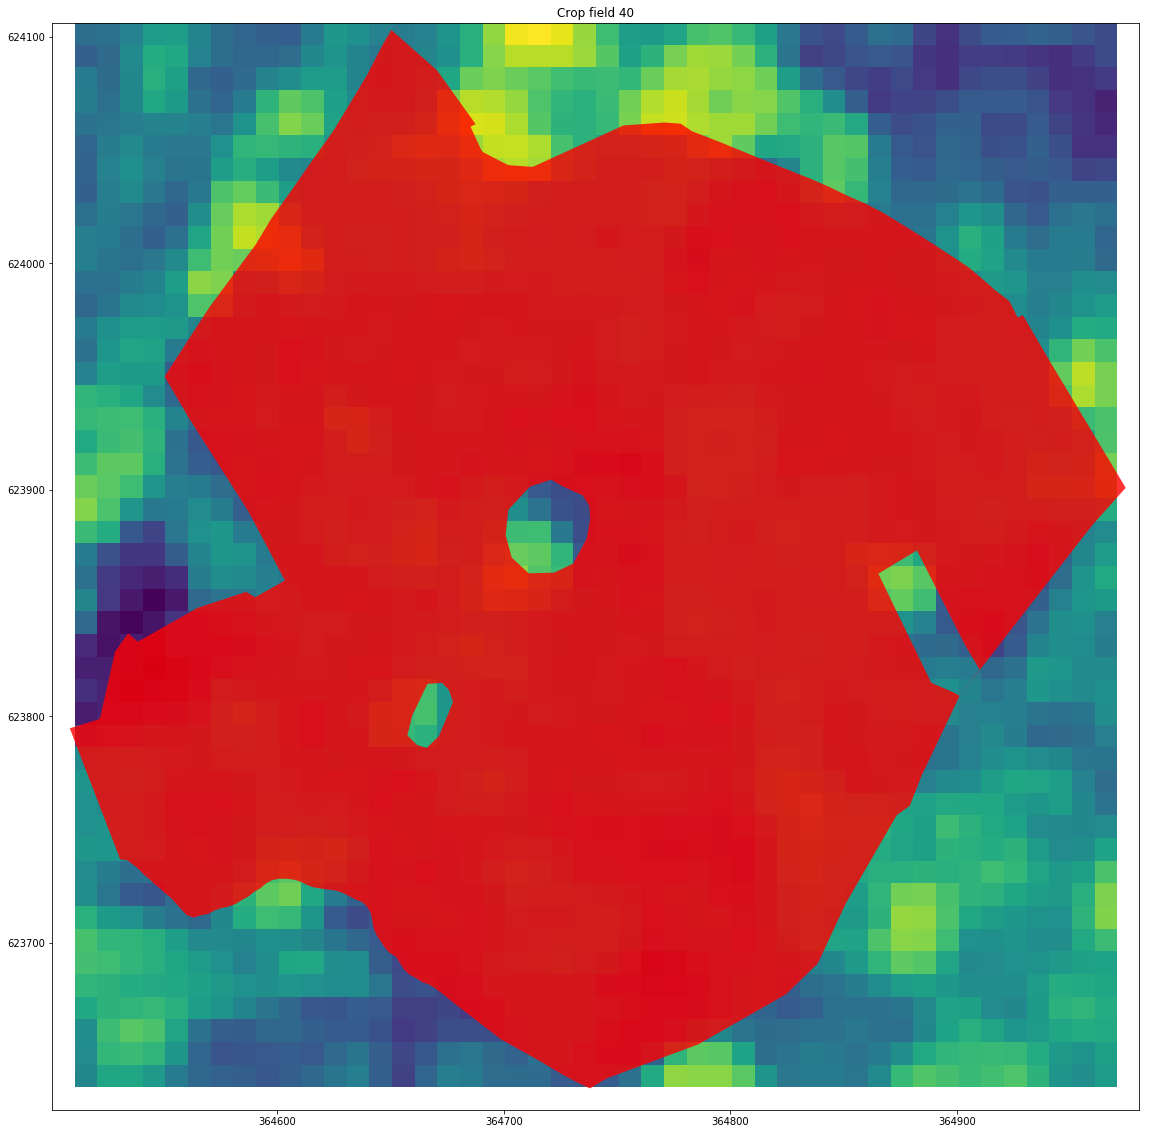

In [13]:
num_row = 15
num_col = 10
num_file = num_row * num_col

fig, ax = pyplot.subplots(figsize=(25, 20))

clipped = rasterio.open("http://data.cropmap.edina.ac.uk/clipped/fields/2/clipped_20180107.tif")
row = int(i/num_col)
col = i % num_col
show(clipped, ax=ax)
ax.set_title("Crop field "+str(i))

shapefile = gpd.read_file('fields.shp')
shapefile[2:3].plot(ax=ax, color='red', alpha=0.8)

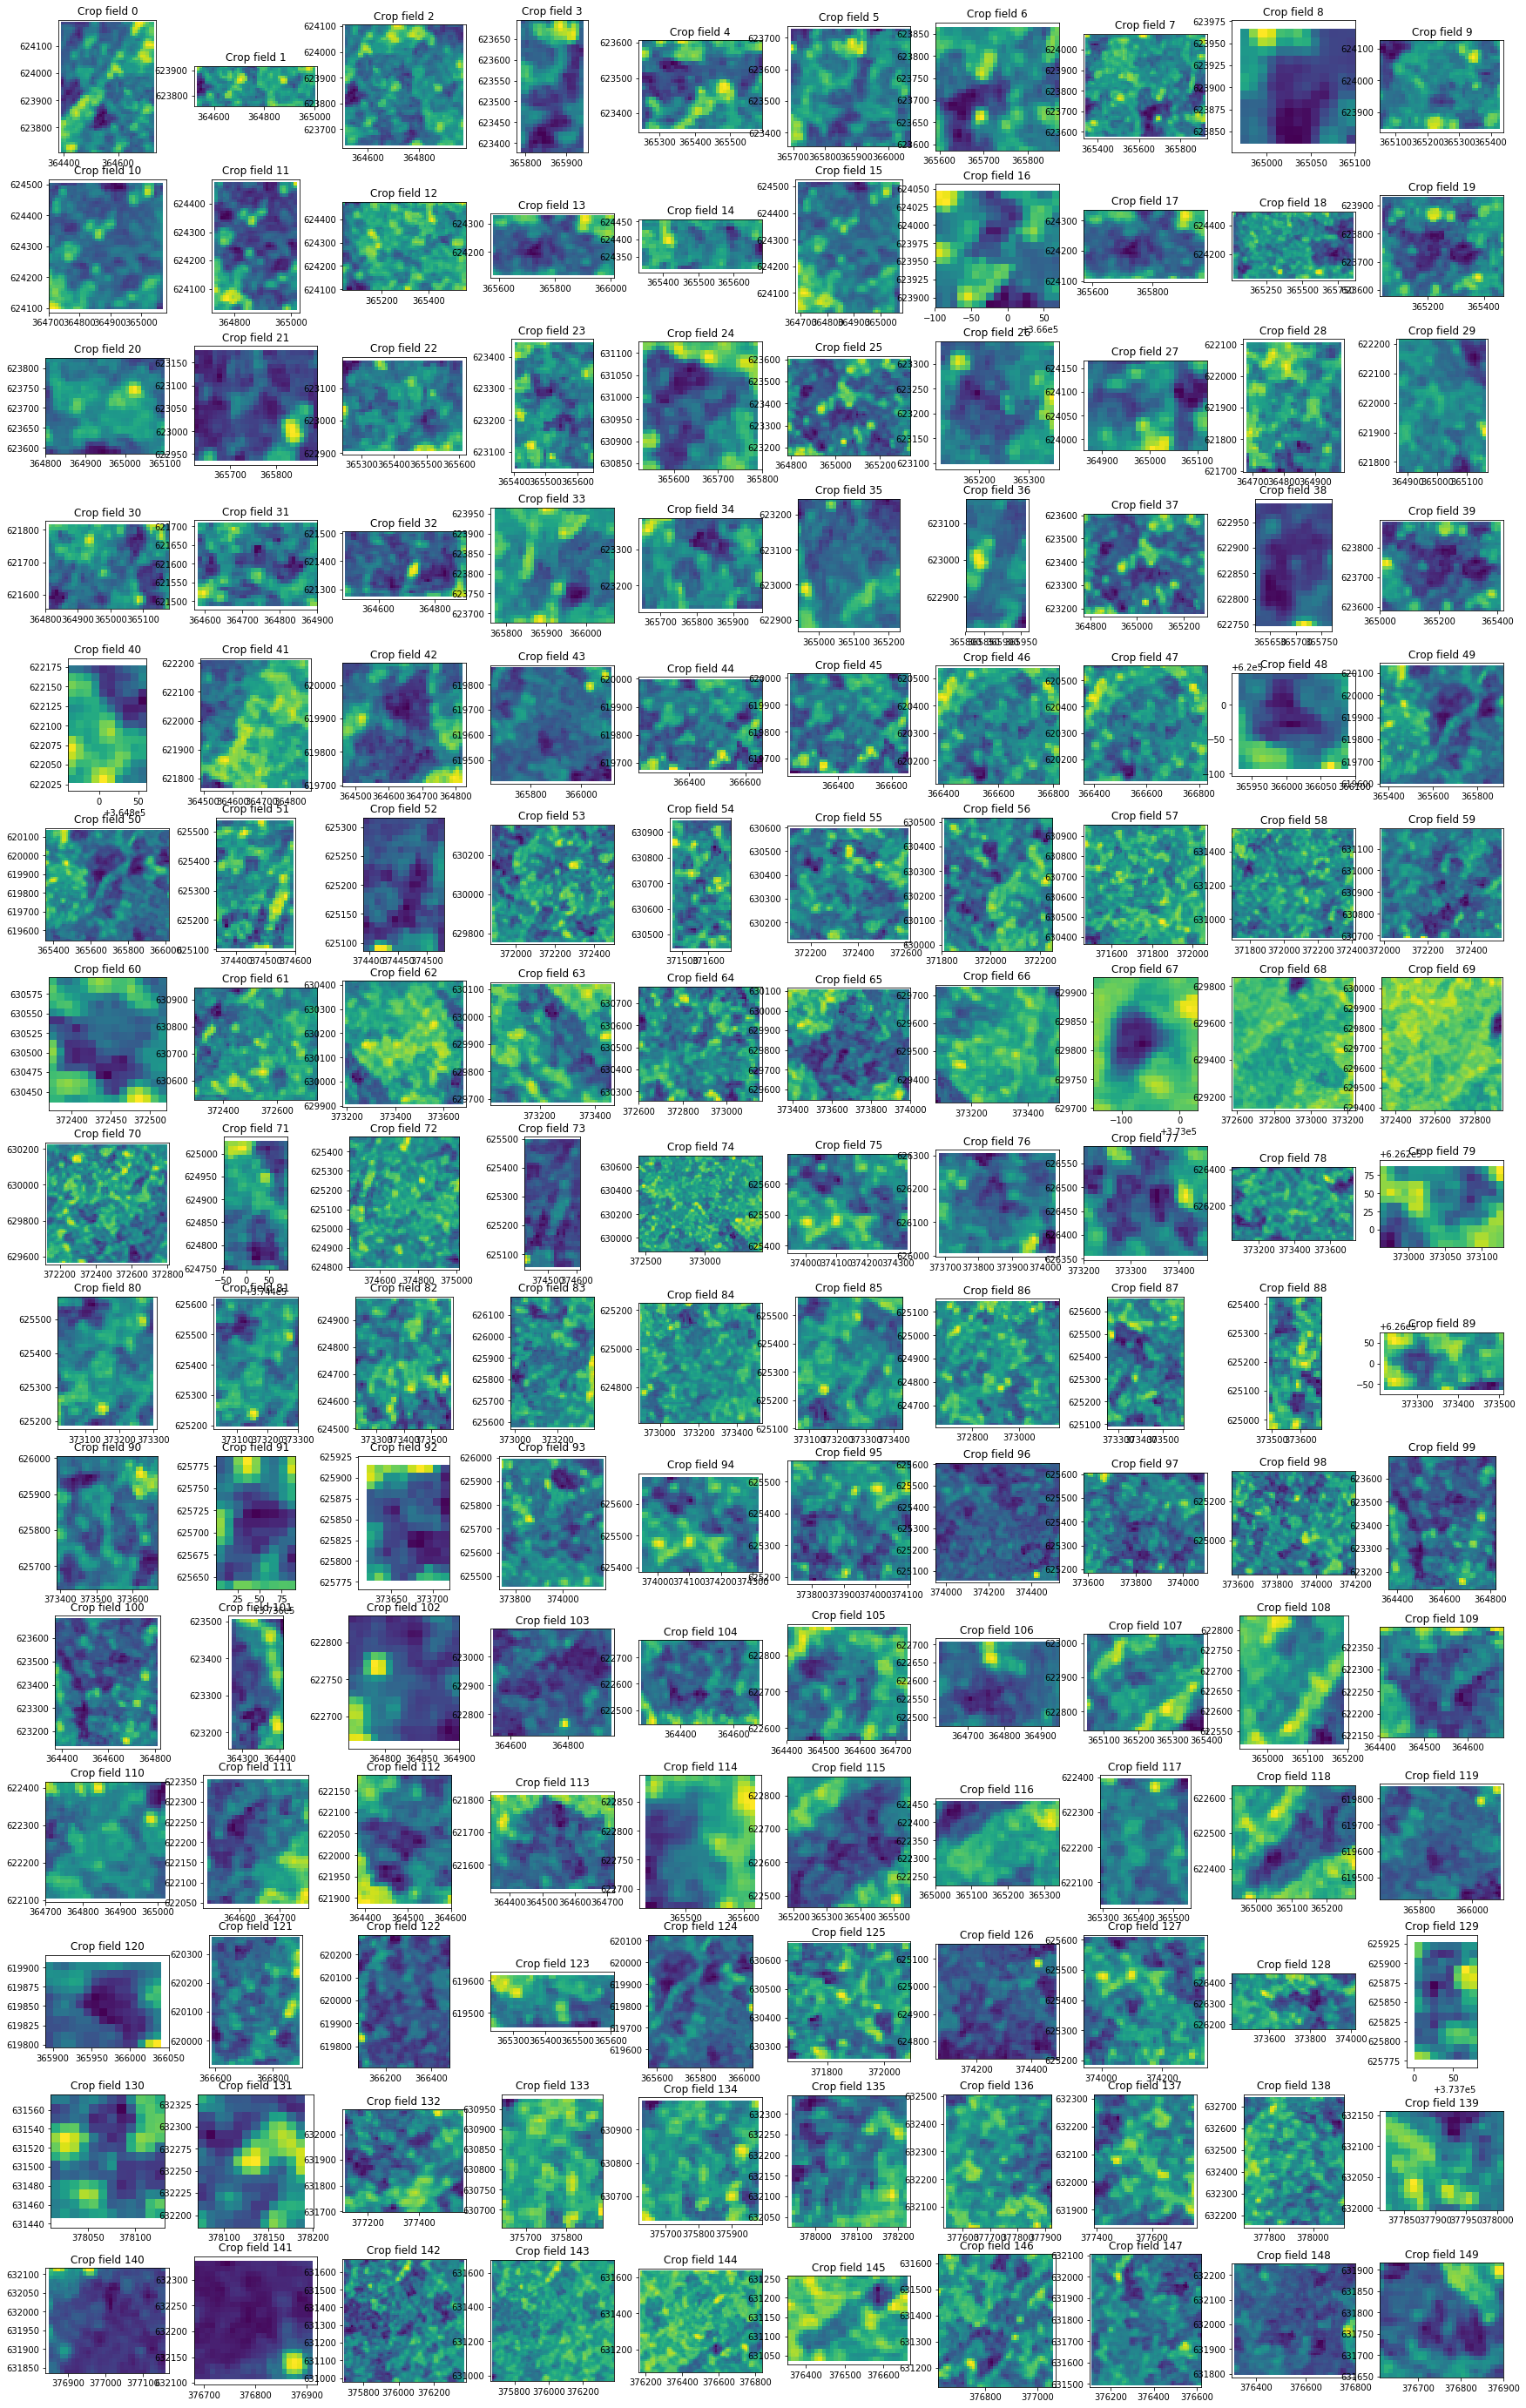

In [88]:
num_row = 15
num_col = 10
num_file = num_row * num_col

fig, axes = pyplot.subplots(num_row, num_col, figsize=(30,50))

for i, file in enumerate(clipped_files[0:num_file], start=0):
    clipped = rasterio.open(r"data/clipped/fields/"+str(i)+"/"+clipped_files[i])
    row = int(i/num_col)
    col = i % num_col
    show(clipped, ax=axes[row][col])
    axes[row][col].set_title("Crop field "+str(i))

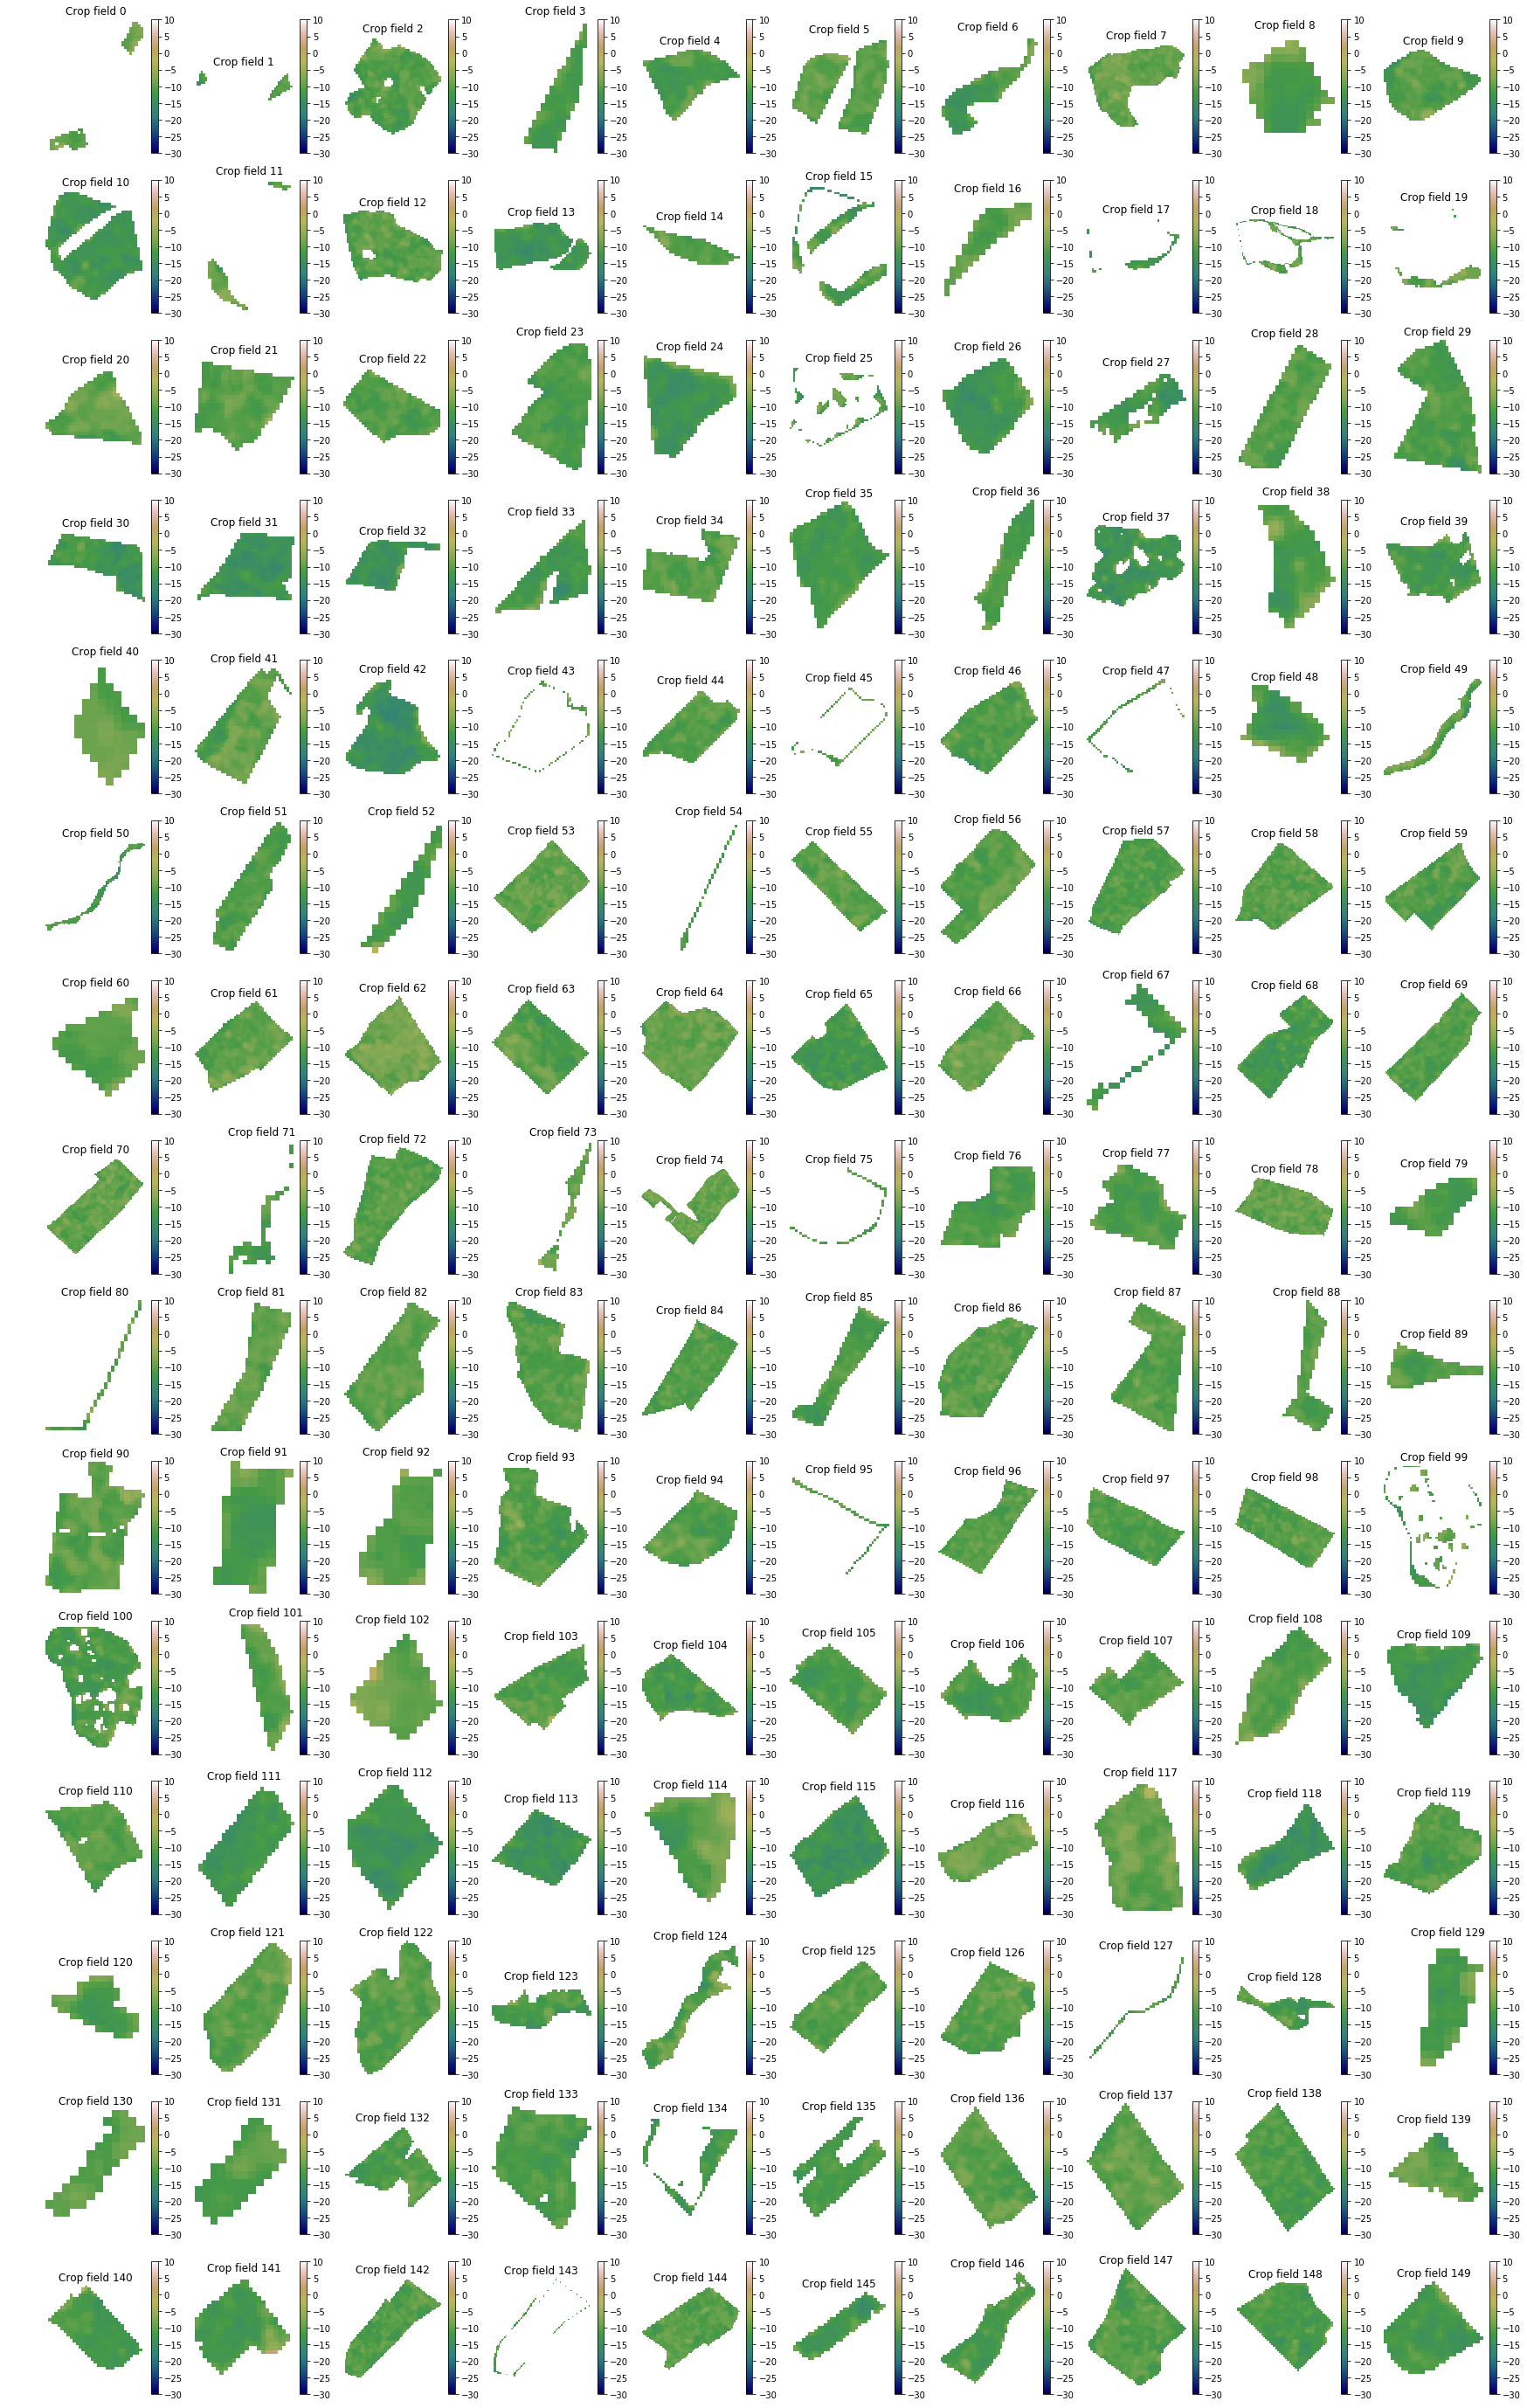

In [86]:
num_row = 15
num_col = 10
fig, axes = pyplot.subplots(num_row, num_col, figsize=(30,50))

# This fake image is just to be able to build a common color bar
# There is probably a nicer way to do it
fake_image = axes[0][0].imshow(np.random.random((40, 40)),
                  cmap='gist_earth',
                  animated=True,
                  vmin=-30,
                  vmax=10
                 )

num_file = num_row * num_col
for i, file in enumerate(clipped_files[0:num_file], start=0):
    clipped = rasterio.open(r"data/clipped/"+str(i)+"/"+clipped_files[i])
    
    # create geojson object from the shapefile imported above
    field_geojson = mapping(shapefile['geometry'][i])
    
    # create mask
    field_crop, field_crop_affine = mask(clipped, [field_geojson], crop=True, indexes=[1])
    
    # Create spatial plotting extent for the cropped layer
    field_extent = plotting_extent(field_crop[0], field_crop_affine)
    
    row = int(i/num_col)
    col = i % num_col
    
    # Plot your data
    image = axes[row][col].imshow(field_crop[0],
                                  extent=field_extent,
                                  cmap='gist_earth',
                                  vmin=-30, 
                                  vmax=10)
    
    fig.colorbar(fake_image, ax=axes[row][col], orientation='vertical');
    axes[row][col].set_title("Crop field "+str(i))
    axes[row][col].set_axis_off()